In [1]:
import meta_poisoning_typical as mp
import mlp

/home/adam/.conda/envs/jax_py311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt

from tqdm import trange, tqdm

In [3]:
from importlib import reload
reload(mp)
reload(mlp)

Params = mlp.Params
MLP = mlp.MLP
ellipsoid_norm = mlp.ellipsoid_norm

# 09-25+ Basin radius

In [4]:
cfg = mp.MetaConfig(num_layers=1, un_xent=True, spherical=True)

In [5]:
seed = 0

if cfg.task == "digits":
    # Load data
    X, Y = mp.load_digits(return_X_y=True)
    X = X / 16.0  # Normalize

    # Split data into "train" and "test" sets
    X_nontest, X_test, Y_nontest, Y_test = mp.train_test_split(
        X, Y, test_size=261, random_state=0, stratify=Y,
    )

    X_train, X_untrain, Y_train, Y_untrain = mp.train_test_split(
        X_nontest, Y_nontest, test_size=768, random_state=0, stratify=Y_nontest,
    )
    
    d_inner = X.shape[1]

    model = MLP(hidden_sizes=(d_inner,) * cfg.num_layers, out_features=10, 
                norm_scale=cfg.norm_scale,
                spherical=cfg.spherical,
                )
else:
    raise ValueError(f"Unknown task: {cfg.task}")

In [6]:
key = jax.random.key(seed)

params_init = model.init(key, X_nontest)

params_init = Params(params_init)

2024-09-26 21:56:36.006969: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version (12.6.68). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [7]:
with open('pinit_0925_spher.npy', 'rb') as f:
    params_spher = mlp.Params(jnp.load(f, allow_pickle=True), params_init.unravel)

print(ellipsoid_norm(params_spher, spherical=True), jnp.linalg.norm(params_spher.raveled))

57.883167 57.883167


In [8]:
params_rand_rav = jax.random.normal(jax.random.key(seed), shape=params_init.raveled.shape)
params_rand_rav *= jnp.linalg.norm(params_spher.raveled) / jnp.linalg.norm(params_rand_rav)
params_rand = Params(params_rand_rav, params_init.unravel)

In [9]:

def log_hyperball_volume(dim):
    return (dim / 2) * jnp.log(jnp.pi) - jax.scipy.special.gammaln(dim / 2 + 1)

def log_hypersphere_area(dim):
    return jnp.log(2) + (dim / 2) * jnp.log(jnp.pi) - jax.scipy.special.gammaln(dim / 2)

def log_small_hyperspherical_cap(dim, h, angle=False):
    x = jnp.sqrt(2 * h - h**2)
    t = jnp.arctan(x / (1 - h))
    logr = jnp.log(t) if angle else jnp.log(x)
    return (dim - 1) * logr + log_hyperball_volume(dim - 1) - log_hypersphere_area(dim)

In [10]:
def metrics(params, x, y):
    logits = model.apply(params.unraveled, x)
    preds = jnp.argmax(logits, axis=1)

    loss = mp.sparse_xent(logits, y).mean()
    acc = jnp.mean(preds == y)
    return loss, acc

In [11]:
cfg = mp.MetaConfig(num_layers=1, un_xent=True, spherical=True)

In [12]:
def final_metrics(params):
    apply_fn = mp.make_apply_full(model, params.unravel)
    poison_loss, (untrain_loss, test_loss, train_loss), state = mp.train(
        params.raveled, X_train, Y_train, X_untrain, Y_untrain, X_test, Y_test, apply_fn, cfg,
        return_state=True,
    )
    
    params_final = Params(state.params['p'], params.unravel)

    train_acc = metrics(params_final, X_train, Y_train)[1]
    test_acc = metrics(params_final, X_test, Y_test)[1]
    return train_acc, test_acc

def current_metrics(params):

    train_acc = metrics(params, X_train, Y_train)[1]
    test_acc = metrics(params, X_test, Y_test)[1]
    return train_acc, test_acc

In [13]:
train_accs_mp_init = []
test_accs_mp_init = []
ell_norms_mp_init = []

xs = jnp.linspace(0, 1, 100)

for mult in tqdm(xs):
    params_mult_rav = (params_rand_rav * mult + params_spher.raveled)
    params_mult_rav *= jnp.linalg.norm(params_spher.raveled) / jnp.linalg.norm(params_mult_rav)
    params_mult = Params(params_mult_rav, params_spher.unravel)

    apply_fn = mp.make_apply_full(model, params_mult.unravel)

    poison_loss, (untrain_loss, test_loss, train_loss), state = mp.train(
        params_mult.raveled, X_train, Y_train, X_untrain, Y_untrain, X_test, Y_test, apply_fn, cfg,
        return_state=True,
        target_norm=ellipsoid_norm(params_spher, spherical=True), unravel=params_spher.unravel,
    )
    
    params_final = Params(state.params['p'], params_mult.unravel)
    ell_norms_mp_init.append(ellipsoid_norm(params_final, spherical=True))
    loss, acc = metrics(params_final, X_train, Y_train)
    train_accs_mp_init.append(acc)
    loss, acc = metrics(params_final, X_test, Y_test)
    test_accs_mp_init.append(acc)
    #print(loss, acc)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [01:26<00:00,  1.16it/s]


In [14]:
params_randinit_rav = jax.random.normal(jax.random.key(seed+10), shape=params_spher.raveled.shape)
params_randinit_rav *= jnp.linalg.norm(params_spher.raveled) / jnp.linalg.norm(params_randinit_rav)
params_randinit = Params(params_randinit_rav, params_spher.unravel)

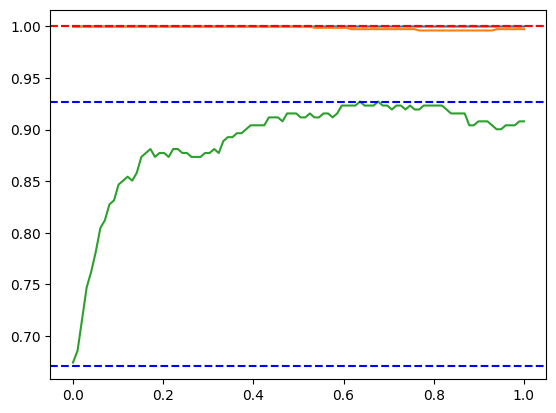

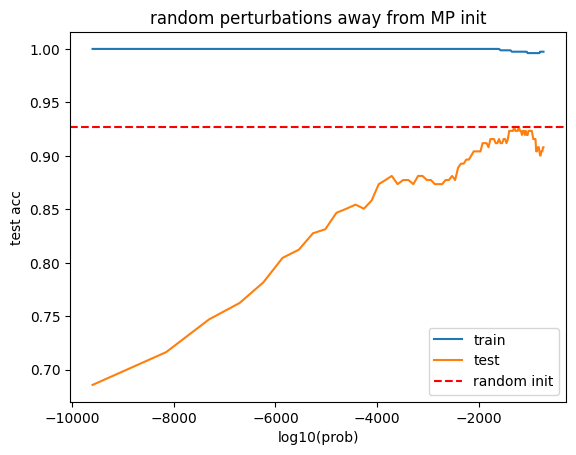

In [15]:
train_init, test_init = final_metrics(params_randinit)
train_spher, test_spher = final_metrics(params_spher)

plt.plot(xs, jnp.array(ell_norms_mp_init) / jnp.linalg.norm(params_spher.raveled))
plt.plot(xs, jnp.array(train_accs_mp_init))
plt.plot(xs, jnp.array(test_accs_mp_init))
# plt.plot(xs, jnp.array(train_accs_0))
# plt.plot(xs, jnp.array(test_accs_0))
# plt.plot(xs, jnp.array(train_accs_1))
# plt.plot(xs, jnp.array(test_accs_1))

# horizontal lines
plt.axhline(train_init, color='r', linestyle='--')
plt.axhline(test_init, color='b', linestyle='--')
plt.axhline(train_spher, color='r', linestyle='--')
plt.axhline(test_spher, color='b', linestyle='--')
plt.show()

dim = params_init.raveled.shape[0]
ys = 1 / jnp.sqrt(xs**2 + 1)
hs = 1 - ys
caps = jnp.array([log_small_hyperspherical_cap(dim, h) / jnp.log(10) for h in hs])

plt.plot(caps, jnp.array(train_accs_mp_init), label='train')
plt.plot(caps, jnp.array(test_accs_mp_init), label='test')
plt.axhline(test_init, color='r', linestyle='--', label='random init')
plt.xlabel("log10(prob)")
plt.ylabel("test acc")
plt.title("random perturbations away from MP init")
plt.legend()
plt.show()


### Jacobian

In [16]:
def train_fn(params_raveled):
    params_raveled = params_raveled * jnp.linalg.norm(params_spher.raveled) / jnp.linalg.norm(params_raveled)
    params = Params(params_raveled, params_init.unravel)

    apply_fn = mp.make_apply_full(model, params.unravel)

    _, _, state = mp.train(
        params_raveled, 
        X_train, Y_train, X_untrain, Y_untrain, X_test, Y_test, 
        apply_fn, cfg,
        target_norm=ellipsoid_norm(params_spher, spherical=True), unravel=params_spher.unravel,
        return_state=True,
    )
    
    return state.params['p']

In [17]:
jac_fn = jax.jacfwd(train_fn)

In [18]:
J = jac_fn(params_spher.raveled)
print(J.shape)

(4810, 4810)


In [35]:
from einops import einsum, rearrange, repeat, reduce

In [46]:
params_unit = params_spher.raveled / jnp.linalg.norm(params_spher.raveled)
proj_param = einsum(params_unit, params_unit, 'i, j -> i j')
proj_orth = jnp.eye(J.shape[0]) - proj_param
# J_orth = proj_orth @ J @ proj_orth
# print(jnp.linalg.norm(J_orth, axis=1))
J_orth2 = J @ proj_orth
print(jnp.linalg.norm(J_orth2, axis=1))

[ 0.98197144 11.488663    3.094256   ...  3.1599658  11.24924
 18.65538   ]


In [47]:
J_unorth = J + proj_param

In [48]:
jnp.linalg.det(J)

Array(0., dtype=float32)

In [40]:
proj_orth.shape

(4810, 4810)

In [49]:
jnp.linalg.matrix_rank(proj_orth)

Array(4809, dtype=int32)

In [50]:
# rank of J
print(jnp.linalg.matrix_rank(J))
# print(jnp.linalg.matrix_rank(J_orth))
print(jnp.linalg.matrix_rank(J_orth2))
print(jnp.linalg.matrix_rank(J_unorth))

4624
4624
4625


In [60]:
two = jnp.array([[2.]])
jnp.linalg.slogdet(two).logabsdet, jnp.log(2)

(Array(0.6931472, dtype=float32),
 Array(0.6931472, dtype=float32, weak_type=True))

In [63]:
print(jnp.linalg.slogdet(J))
print(jnp.linalg.slogdet(J_unorth))
print(jnp.linalg.slogdet(J_orth2))

SlogdetResult(sign=Array(1., dtype=float32), logabsdet=Array(-1405.8884, dtype=float32))
SlogdetResult(sign=Array(1., dtype=float32), logabsdet=Array(-1389.7759, dtype=float32))
SlogdetResult(sign=Array(-1., dtype=float32), logabsdet=Array(-1344.0205, dtype=float32))


In [64]:
u, s, vt = jnp.linalg.svd(J)

In [65]:
u_unorth, s_unorth, vt_unorth = jnp.linalg.svd(J_unorth)

In [66]:
u_orth2, s_orth2, vt_orth2 = jnp.linalg.svd(J_orth2)

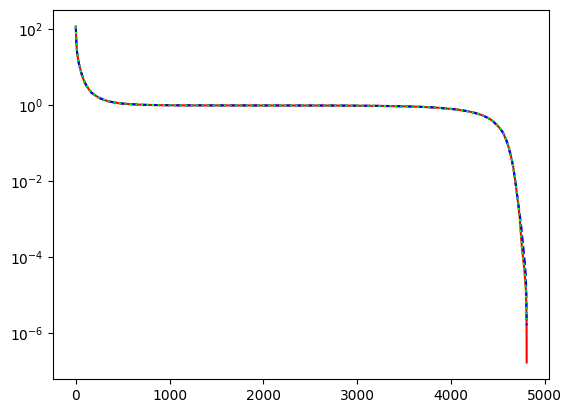

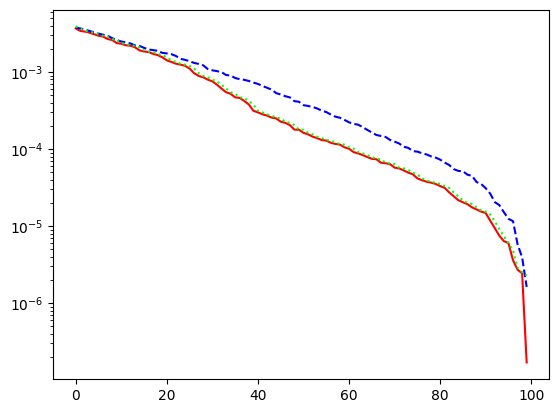

In [76]:



plt.plot(s, color='r')
plt.plot(s_orth2, linestyle='--', color='b')
plt.plot(s_unorth, linestyle=':', color='#00FF00')
plt.yscale('log')
plt.show()


plt.plot(s[-100:], color='r')
plt.plot(s_orth2[-100:], linestyle='--', color='b')
plt.plot(s_unorth[-100:], linestyle=':', color='#00FF00')
plt.yscale('log')
plt.show()

In [83]:
cosine_sim = vt[-1] @ params_unit
print(cosine_sim)

0.43696558


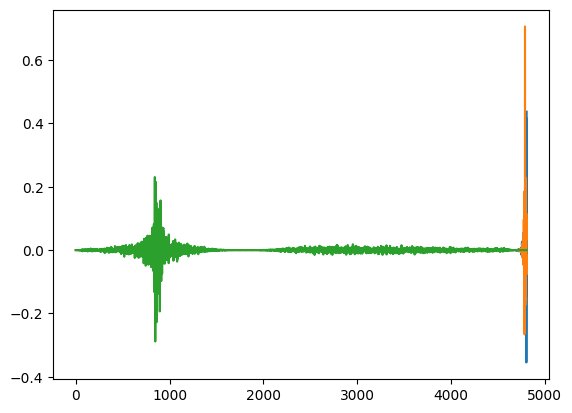

In [78]:
sims = vt @ params_unit
sims_orth2 = vt_orth2 @ params_unit
sim_unorth = vt_unorth @ params_unit
plt.plot(sims[:])
plt.plot(sims_orth2[:])
plt.plot(sim_unorth[:])
plt.show()

In [79]:
jnp.sum(jnp.log10(s))

Array(-610.0084, dtype=float32)

In [80]:
jnp.sum(jnp.log10(s_unorth))

Array(-603.6118, dtype=float32)

In [83]:
jnp.linalg.slogdet(J).logabsdet / jnp.log(10)

Array(-610.5696, dtype=float32)

In [82]:
jnp.linalg.slogdet(J_unorth).logabsdet / jnp.log(10)

Array(-603.572, dtype=float32)

### Testing linearity

[0.9999997 1.0000002 1.0000001 ... 1.        1.        1.       ]


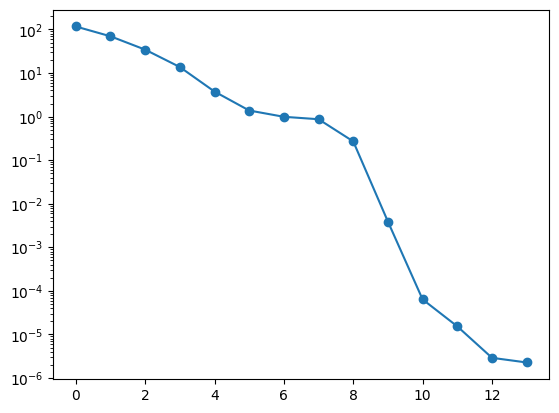


mag: 1.000000e-05


100%|██████████| 14/14 [00:10<00:00,  1.31it/s]



mag: 1.000000e-04


100%|██████████| 14/14 [00:11<00:00,  1.27it/s]



mag: 1.000000e-03


100%|██████████| 14/14 [00:10<00:00,  1.33it/s]



mag: 1.000000e-02


100%|██████████| 14/14 [00:10<00:00,  1.38it/s]



mag: 1.000000e-01


100%|██████████| 14/14 [00:10<00:00,  1.31it/s]



mag: 1.000000e+00


100%|██████████| 14/14 [00:10<00:00,  1.31it/s]


In [100]:
params_init_rav = params_spher.raveled
params_final_rav = train_fn(params_spher.raveled)
print(jnp.linalg.norm(vt_unorth, axis=1))

indices = [0, 3, 10, 30, 100, 300, 1000, -1000, -300, -100, -30, -10, -3, -1]
mags = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0]

actual_svs = [s_unorth[i] for i in indices]

plt.plot(actual_svs, 'o-')
plt.yscale('log')
plt.show()

all_diffs = []
all_svs = []

for mag in mags:
    print()
    print(f'mag: {mag:e}')

    diffs = []
    svs = []

    for i in tqdm(indices):
        pert = vt_unorth[i] * mag
        params_final_pert_rav = train_fn(params_init_rav + pert)
        diff = jnp.linalg.norm(params_final_rav - params_final_pert_rav)
        diffs.append(diff)
        svs.append(s_unorth[i] * mag)

    all_diffs.append(diffs)
    all_svs.append(svs)

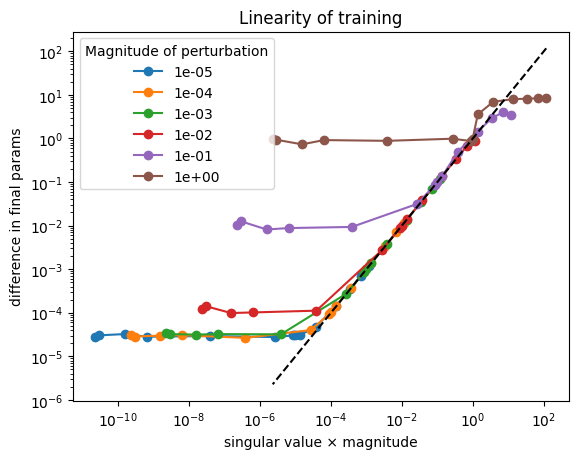

In [104]:
for diffs, svs, mag in zip(all_diffs, all_svs, mags):
    plt.plot(svs, diffs, 'o-', label=f'{mag:.0e}')
plt.plot(svs, svs, linestyle='--', color='k')
plt.legend(title='Magnitude of perturbation')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('singular value × magnitude')
plt.ylabel('difference in final params')
plt.title('Linearity of training')
plt.show()

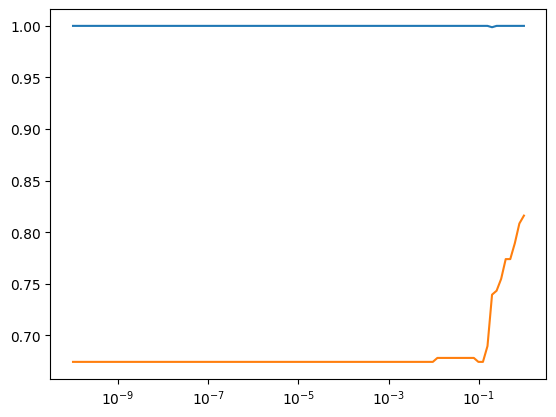

In [107]:
xs = 10**jnp.linspace(-10, 0, 100)

train_accs_pert = []
test_accs_pert = []


for mult in xs:
    pert = vt_unorth[30] * mult
    params_final_pert_rav = train_fn(params_init_rav + pert)
    params_final_pert = Params(params_final_pert_rav, params_spher.unravel)

    train_acc = metrics(params_final_pert, X_train, Y_train)[1]
    test_acc = metrics(params_final_pert, X_test, Y_test)[1]
    train_accs_pert.append(train_acc)
    test_accs_pert.append(test_acc)
    
plt.plot(xs, jnp.array(train_accs_pert))
plt.plot(xs, jnp.array(test_accs_pert))
plt.xscale('log')
plt.show()

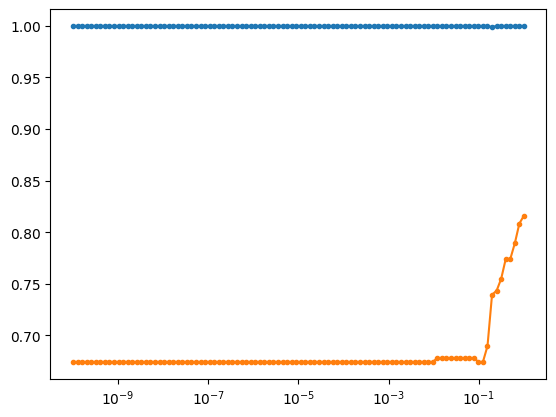

In [113]:

plt.plot(xs, jnp.array(train_accs_pert), '.-')
plt.plot(xs, jnp.array(test_accs_pert), '.-')
plt.xscale('log')
plt.show()

#### v init

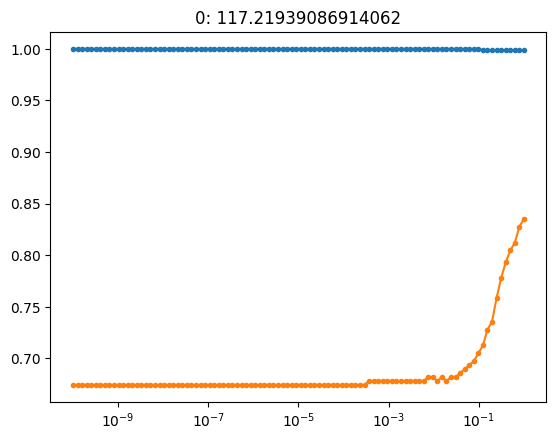

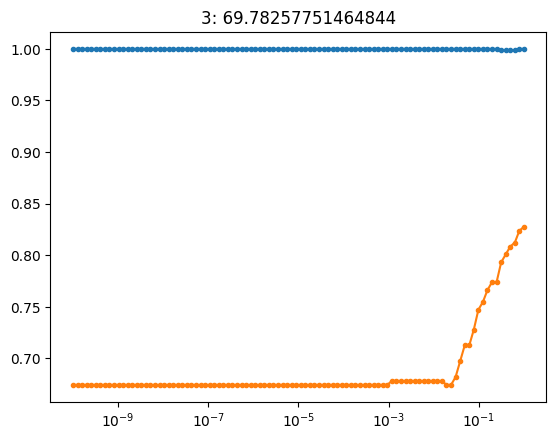

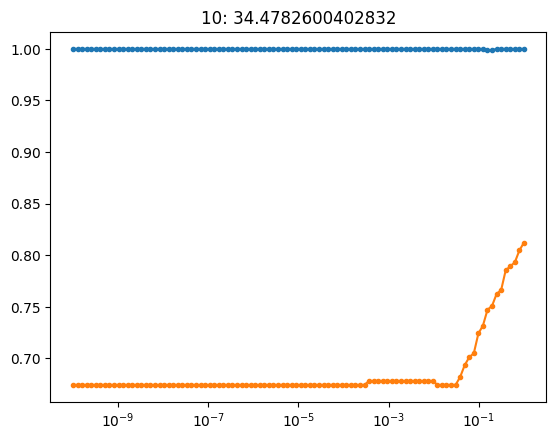

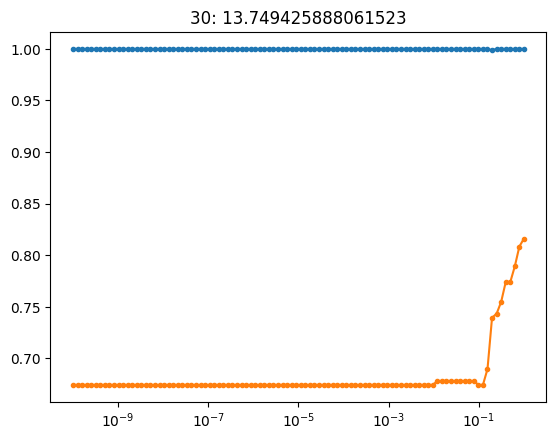

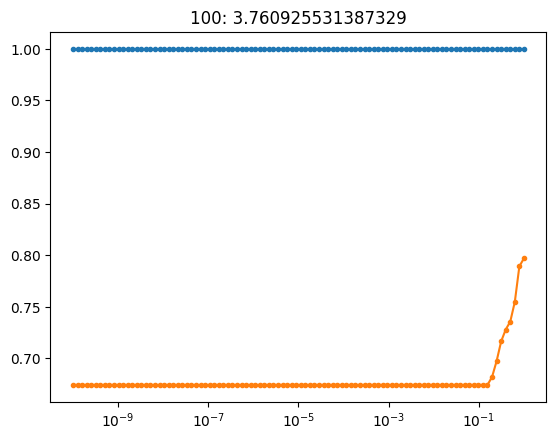

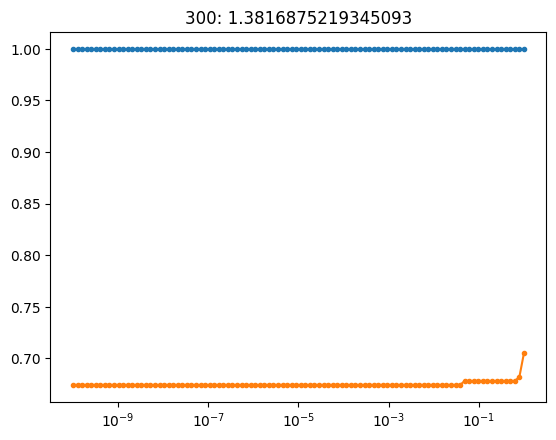

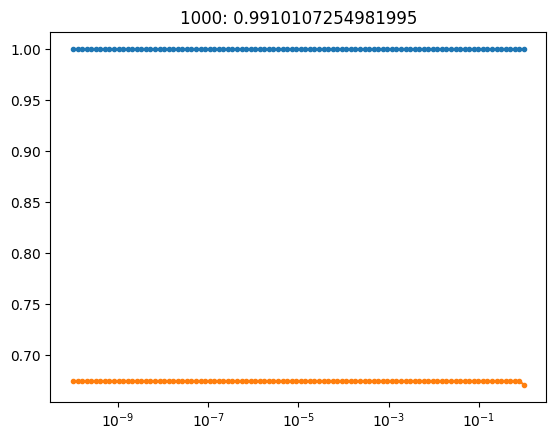

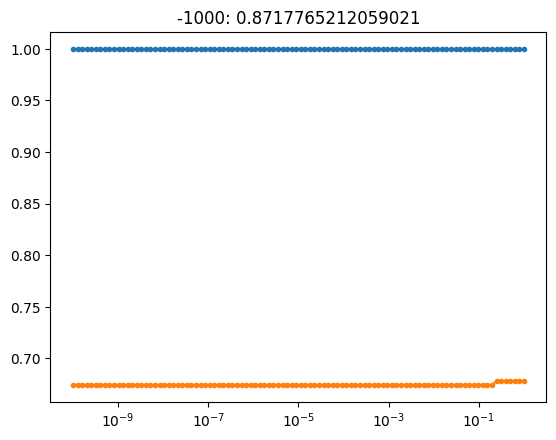

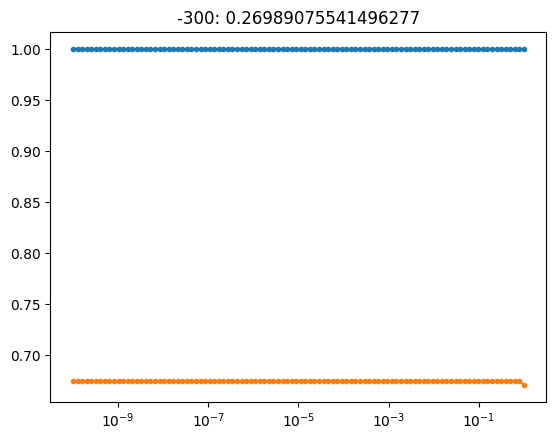

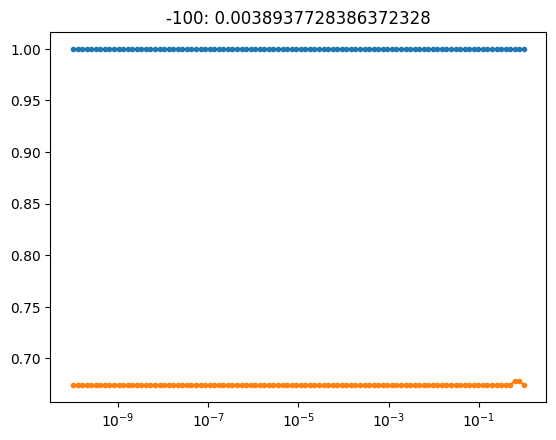

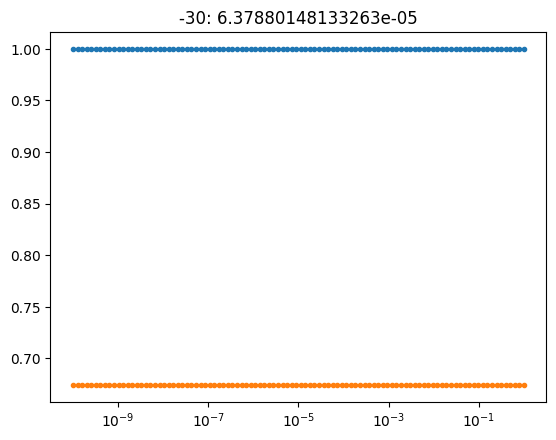

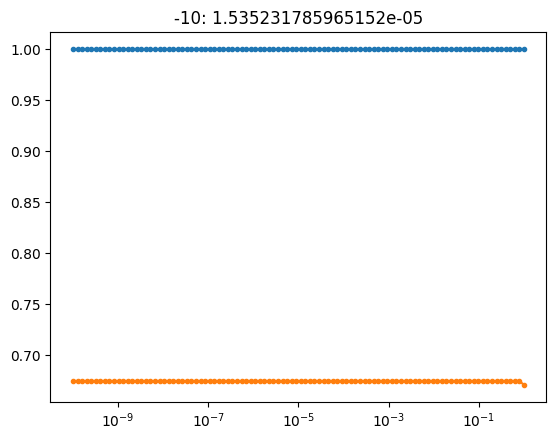

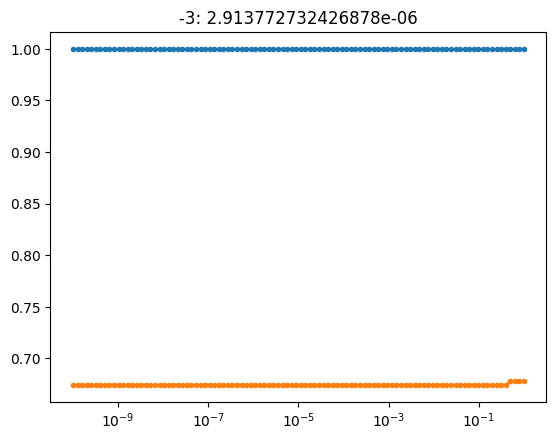

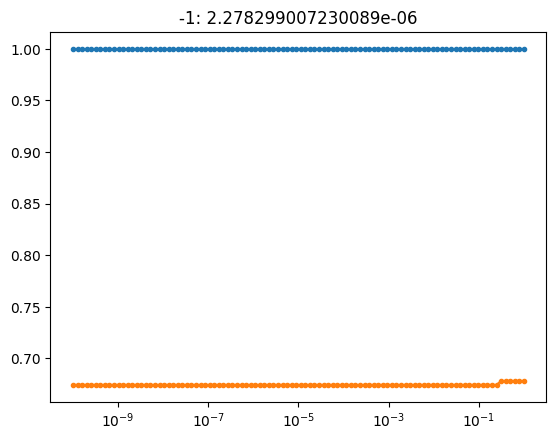

In [116]:
xs = 10**jnp.linspace(-10, 0, 100)


for i in indices:
    train_accs_pert = []
    test_accs_pert = []
    train_accs_neg_pert = []
    test_accs_neg_pert = []
    
    for mult in xs:
        pert = vt_unorth[i] * mult
        params_final_pert_rav = train_fn(params_init_rav + pert)
        params_final_pert = Params(params_final_pert_rav, params_spher.unravel)

        train_acc = metrics(params_final_pert, X_train, Y_train)[1]
        test_acc = metrics(params_final_pert, X_test, Y_test)[1]
        train_accs_pert.append(train_acc)
        test_accs_pert.append(test_acc)
        
        pert = -vt_unorth[i] * mult
        params_final_pert_rav = train_fn(params_init_rav + pert)
        params_final_pert = Params(params_final_pert_rav, params_spher.unravel)

        train_acc = metrics(params_final_pert, X_train, Y_train)[1]
        test_acc = metrics(params_final_pert, X_test, Y_test)[1]
        train_accs_neg_pert.append(train_acc)
        test_accs_neg_pert.append(test_acc)
        
    plt.plot(xs, jnp.array(train_accs_pert), '.-', label='train')
    plt.plot(xs, jnp.array(test_accs_pert), '.-', label='test')
    plt.plot(xs, jnp.array(train_accs_neg_pert), '.-', label='train')
    plt.plot(xs, jnp.array(test_accs_neg_pert), '.-', label='test')
    plt.xscale('log')
    plt.title(f'{i}: {s_unorth[i]}')
    plt.show()

#### v init updated

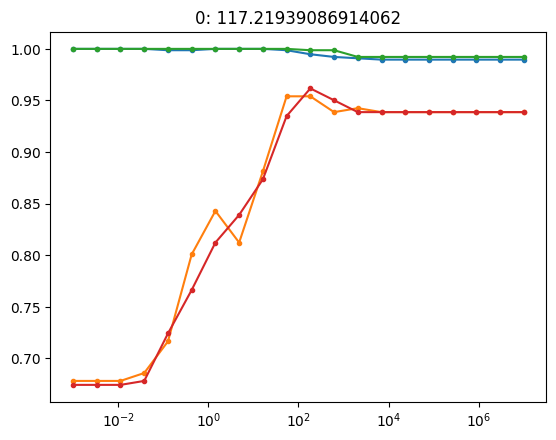

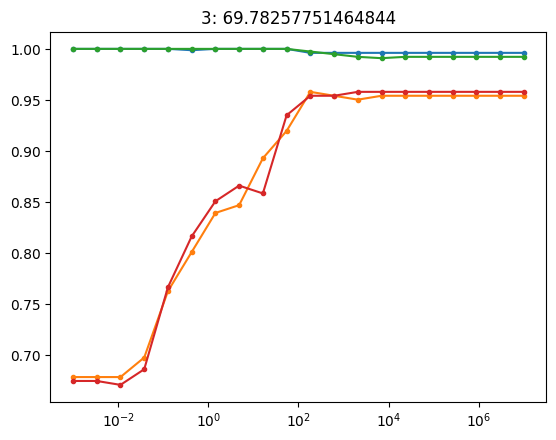

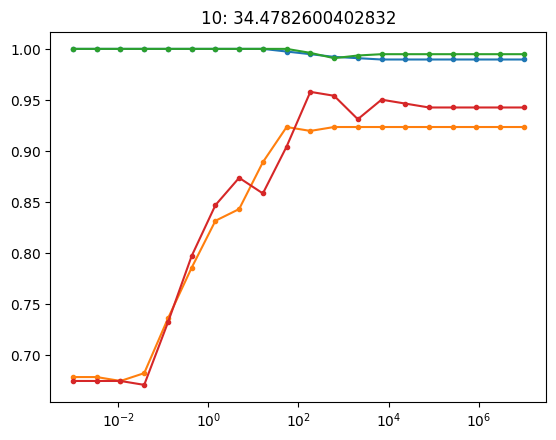

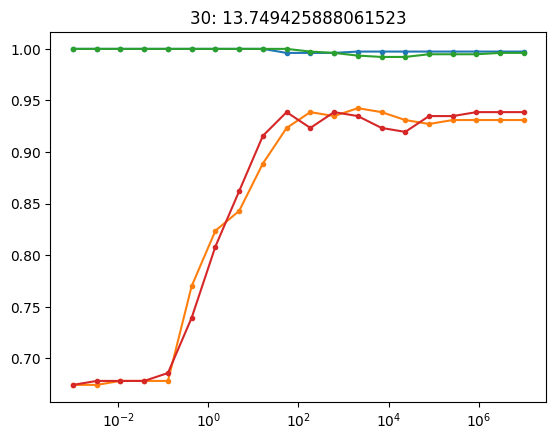

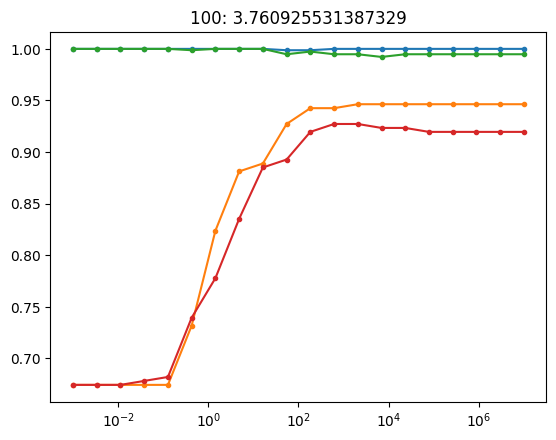

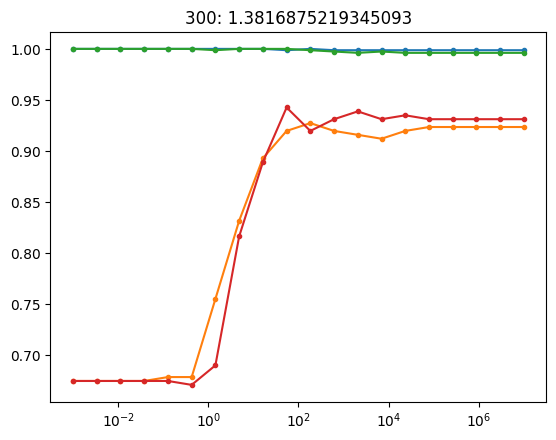

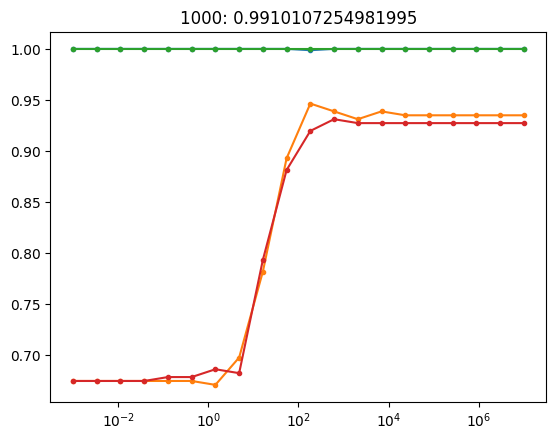

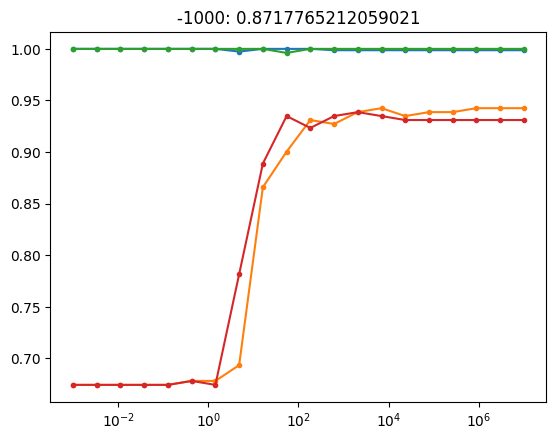

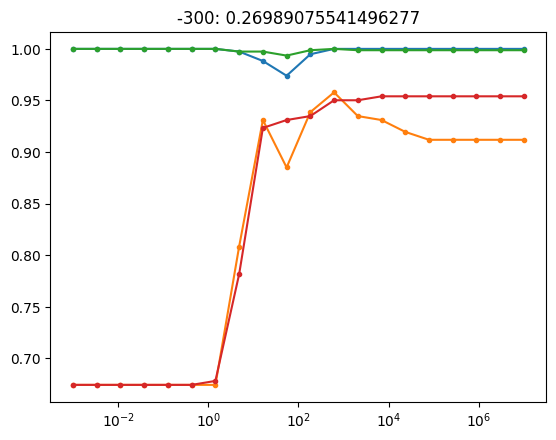

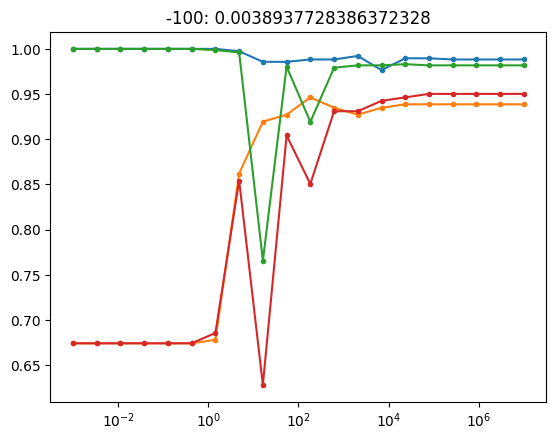

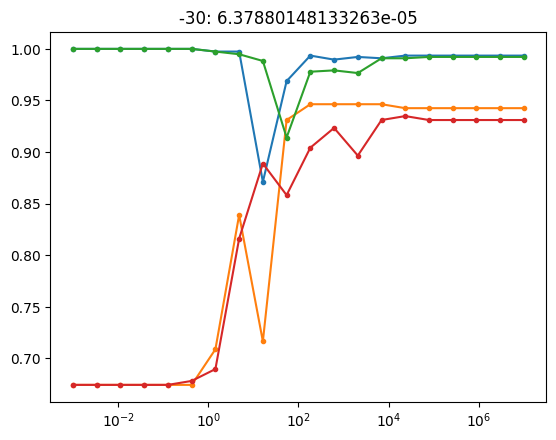

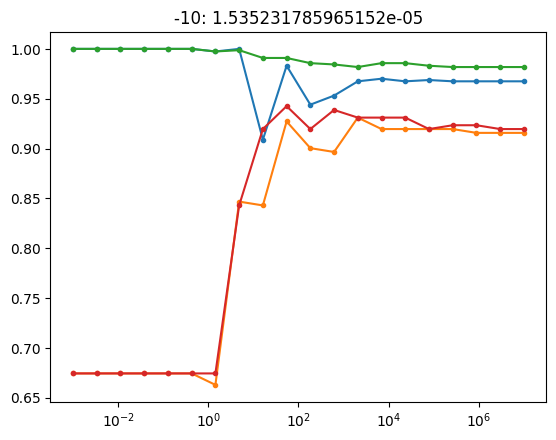

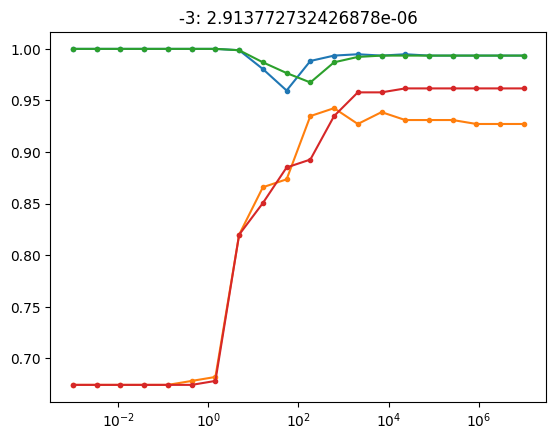

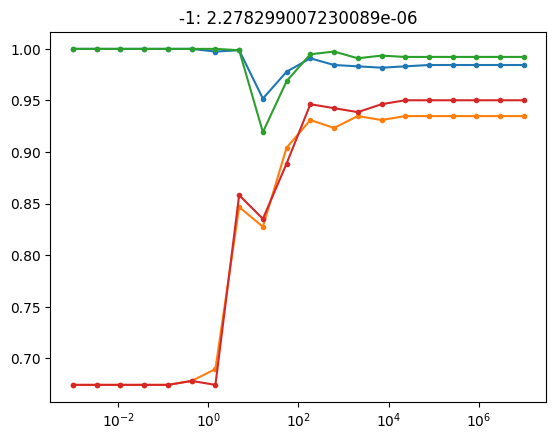

In [120]:
xs = 10**jnp.linspace(-3, 7, 20)


for i in indices:
    train_accs_pert = []
    test_accs_pert = []
    train_accs_neg_pert = []
    test_accs_neg_pert = []
    
    for mult in xs:
        pert = vt_unorth[i] * mult
        params_final_pert_rav = train_fn(params_init_rav + pert)
        params_final_pert = Params(params_final_pert_rav, params_spher.unravel)

        train_acc = metrics(params_final_pert, X_train, Y_train)[1]
        test_acc = metrics(params_final_pert, X_test, Y_test)[1]
        train_accs_pert.append(train_acc)
        test_accs_pert.append(test_acc)
        
        pert = -vt_unorth[i] * mult
        params_final_pert_rav = train_fn(params_init_rav + pert)
        params_final_pert = Params(params_final_pert_rav, params_spher.unravel)

        train_acc = metrics(params_final_pert, X_train, Y_train)[1]
        test_acc = metrics(params_final_pert, X_test, Y_test)[1]
        train_accs_neg_pert.append(train_acc)
        test_accs_neg_pert.append(test_acc)
        
    plt.plot(xs, jnp.array(train_accs_pert), '.-', label='train')
    plt.plot(xs, jnp.array(test_accs_pert), '.-', label='test')
    plt.plot(xs, jnp.array(train_accs_neg_pert), '.-', label='train')
    plt.plot(xs, jnp.array(test_accs_neg_pert), '.-', label='test')
    plt.xscale('log')
    plt.title(f'{i}: {s_unorth[i]}')
    plt.show()

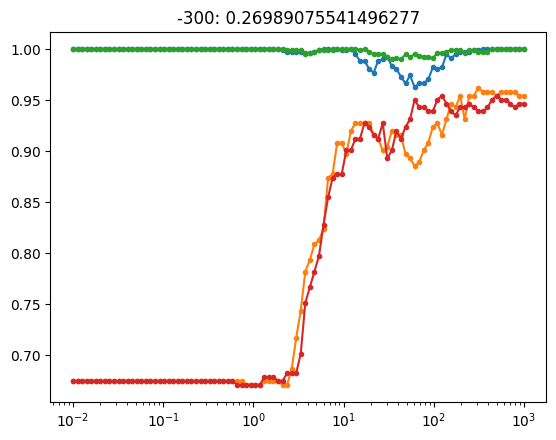

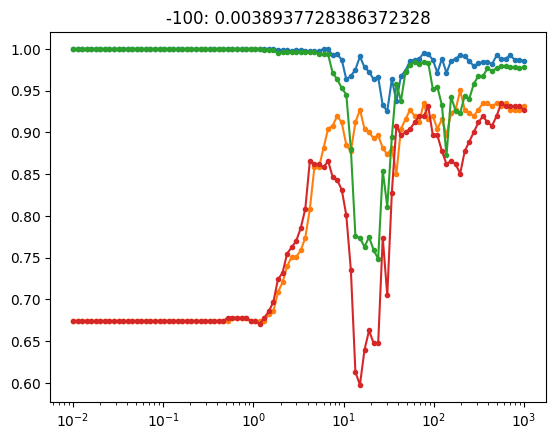

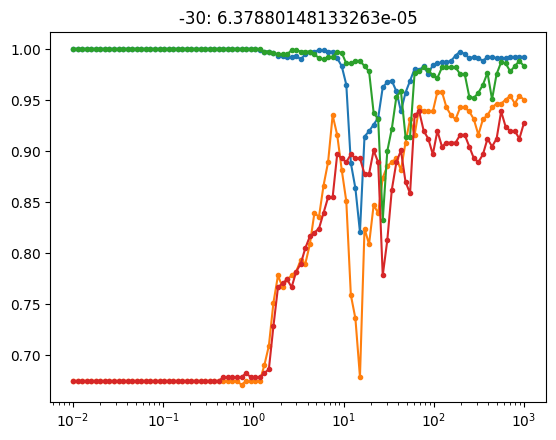

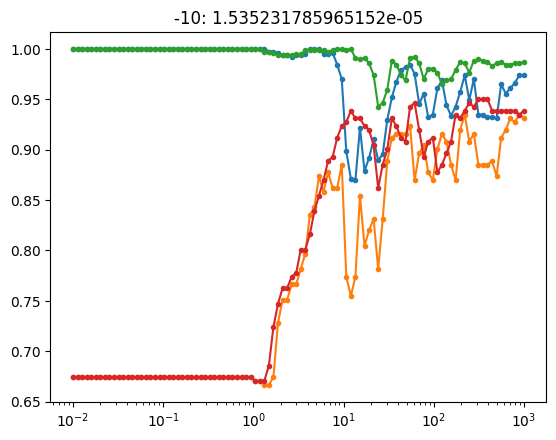

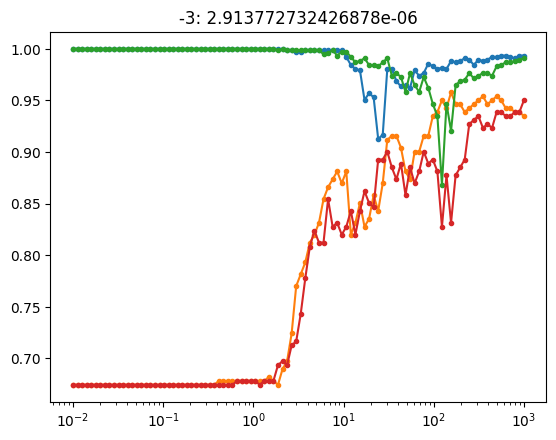

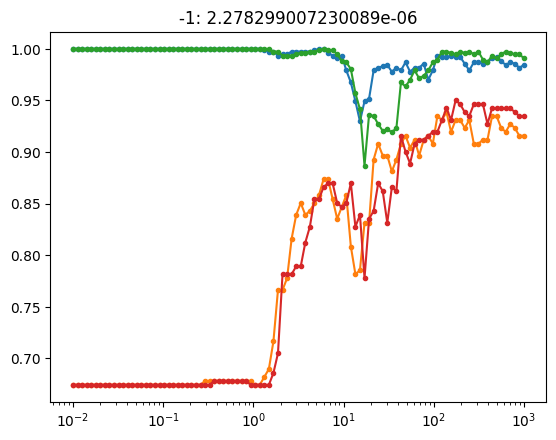

In [144]:
xs = 10**jnp.linspace(-2, 3, 100)


for i in indices[-6:]:
    train_accs_pert = []
    test_accs_pert = []
    train_accs_neg_pert = []
    test_accs_neg_pert = []
    
    for mult in xs:
        pert = vt_unorth[i] * mult
        params_final_pert_rav = train_fn(params_init_rav + pert)
        params_final_pert = Params(params_final_pert_rav, params_spher.unravel)

        train_acc = metrics(params_final_pert, X_train, Y_train)[1]
        test_acc = metrics(params_final_pert, X_test, Y_test)[1]
        train_accs_pert.append(train_acc)
        test_accs_pert.append(test_acc)
        
        pert = -vt_unorth[i] * mult
        params_final_pert_rav = train_fn(params_init_rav + pert)
        params_final_pert = Params(params_final_pert_rav, params_spher.unravel)

        train_acc = metrics(params_final_pert, X_train, Y_train)[1]
        test_acc = metrics(params_final_pert, X_test, Y_test)[1]
        train_accs_neg_pert.append(train_acc)
        test_accs_neg_pert.append(test_acc)
        
    plt.plot(xs, jnp.array(train_accs_pert), '.-', label='train')
    plt.plot(xs, jnp.array(test_accs_pert), '.-', label='test')
    plt.plot(xs, jnp.array(train_accs_neg_pert), '.-', label='train')
    plt.plot(xs, jnp.array(test_accs_neg_pert), '.-', label='test')
    plt.xscale('log')
    plt.title(f'{i}: {s_unorth[i]}')
    plt.show()

#### v final

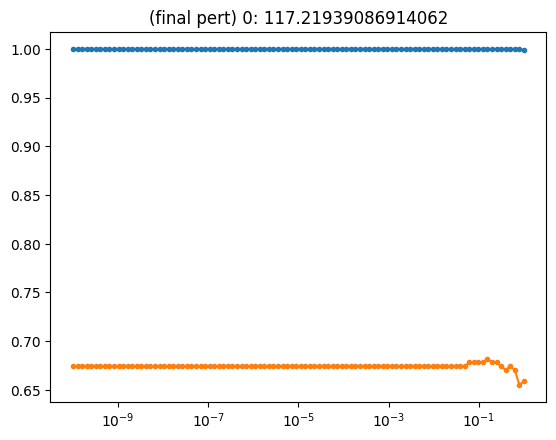

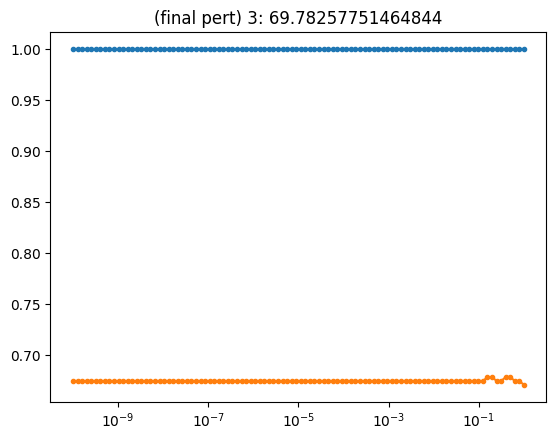

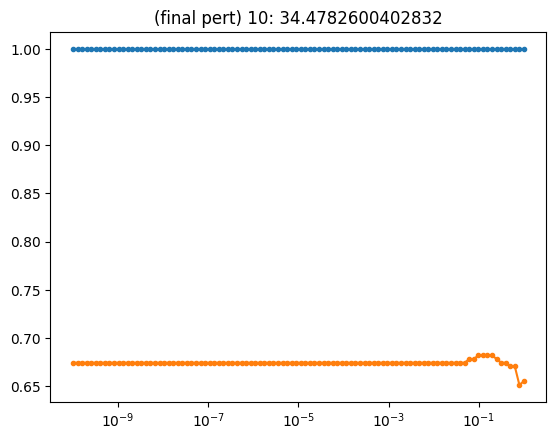

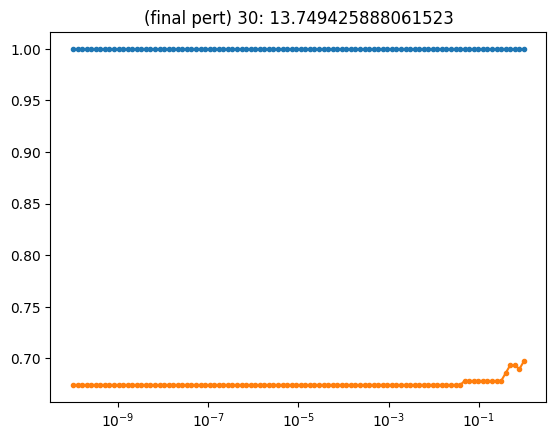

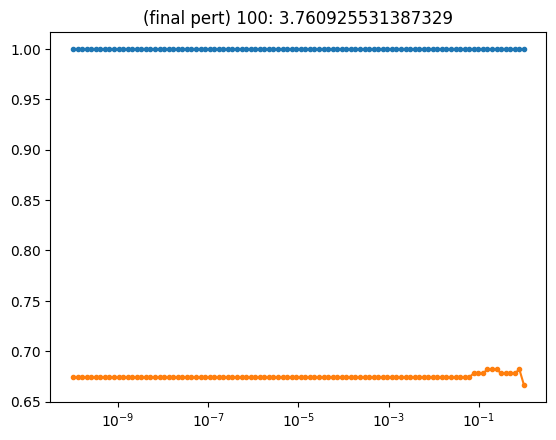

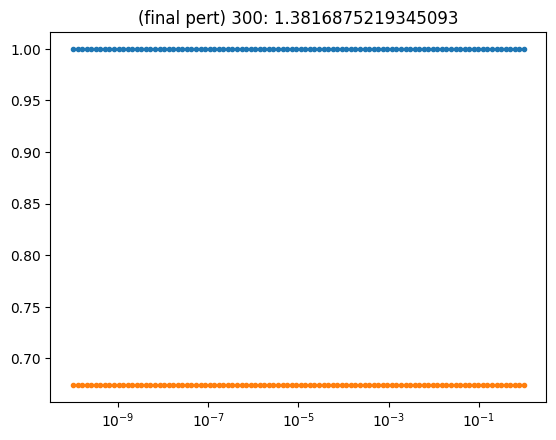

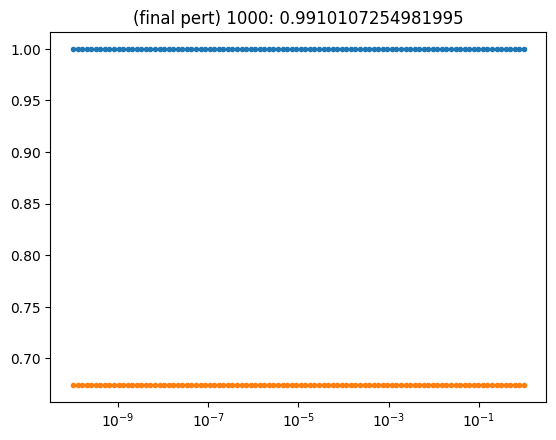

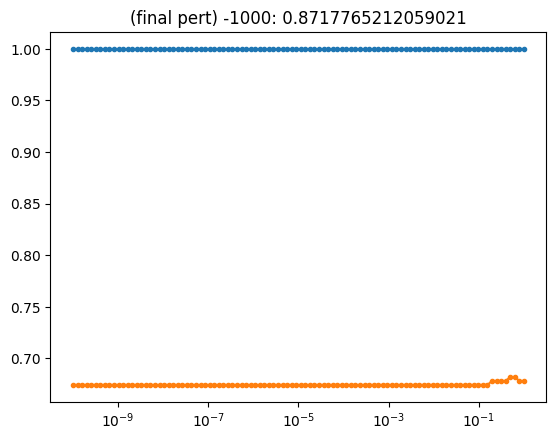

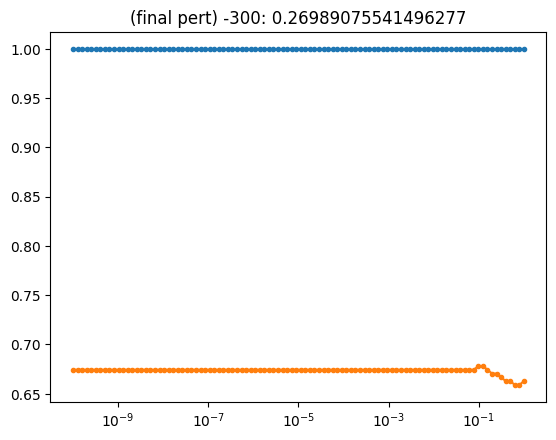

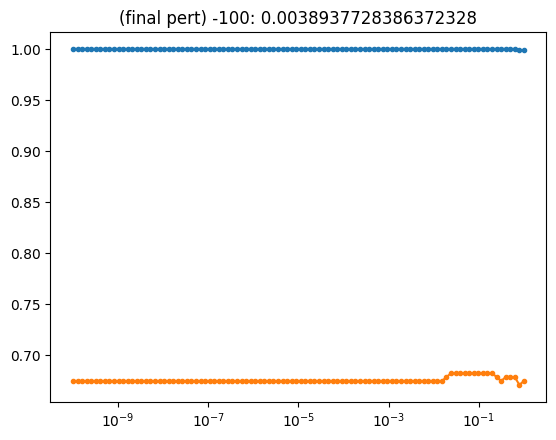

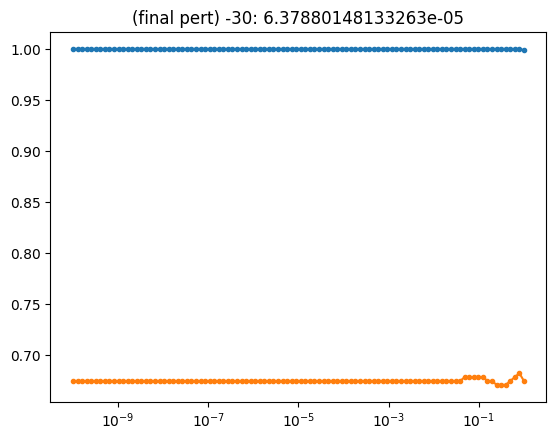

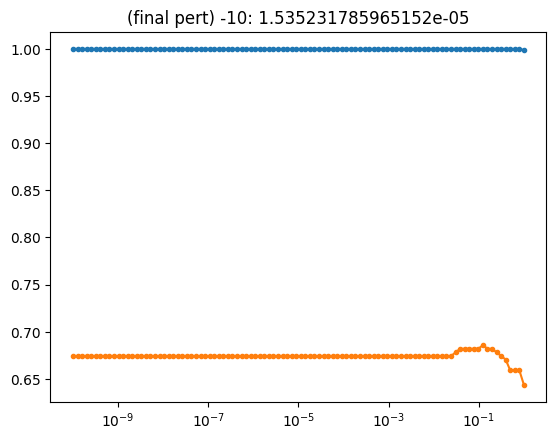

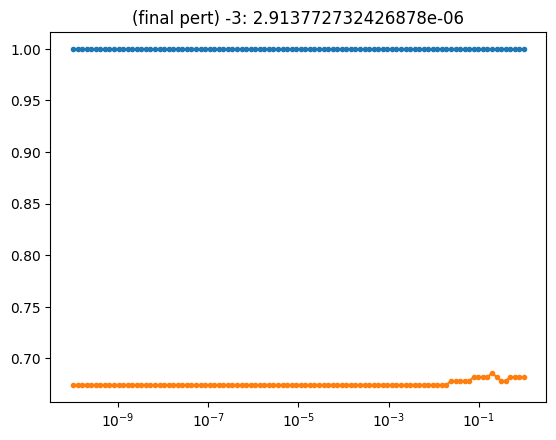

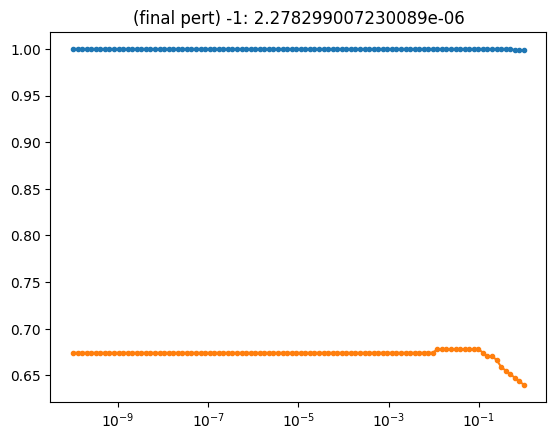

In [117]:
xs = 10**jnp.linspace(-10, 0, 100)


params_final_rav = train_fn(params_init_rav)
params_final = Params(params_final_rav, params_spher.unravel)

for i in indices:
    train_accs_pert = []
    test_accs_pert = []
    
    for mult in xs:
        pert = vt_unorth[i] * mult
        params_final_rav_pert = params_final_rav + pert
        params_final_pert = Params(params_final_rav_pert, params_spher.unravel)

        train_acc = metrics(params_final_pert, X_train, Y_train)[1]
        test_acc = metrics(params_final_pert, X_test, Y_test)[1]
        train_accs_pert.append(train_acc)
        test_accs_pert.append(test_acc)
        
    plt.plot(xs, jnp.array(train_accs_pert), '.-', label='train')
    plt.plot(xs, jnp.array(test_accs_pert), '.-', label='test')
    plt.xscale('log')
    plt.title(f'(final pert) {i}: {s_unorth[i]}')
    plt.show()

#### u final


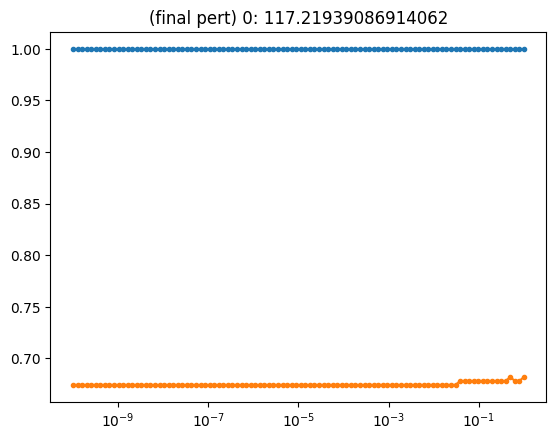

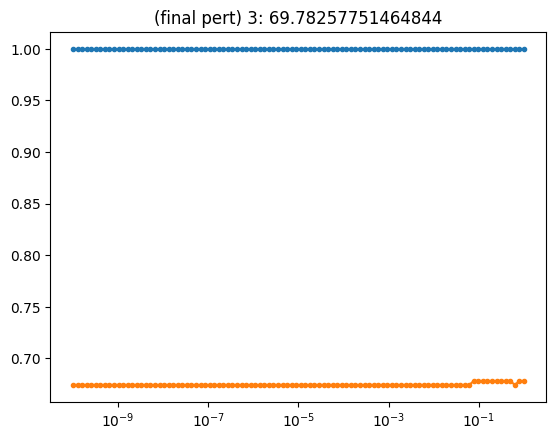

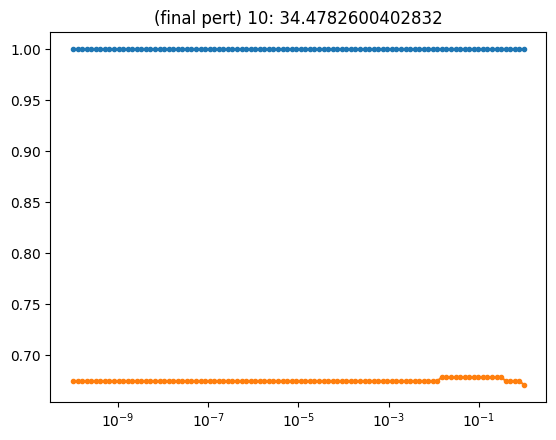

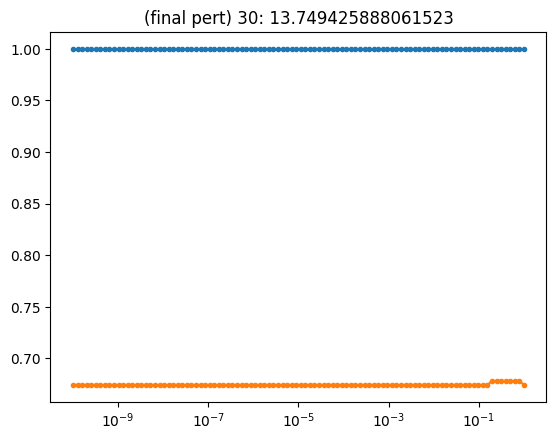

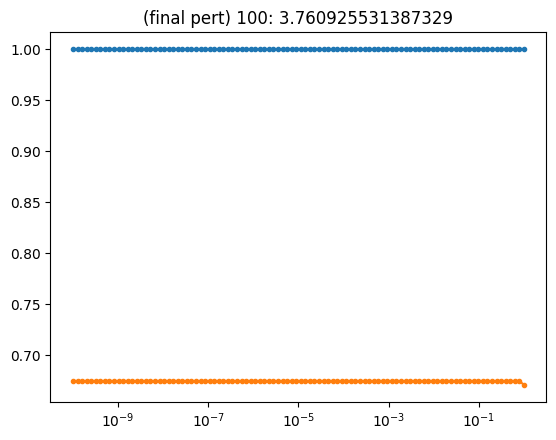

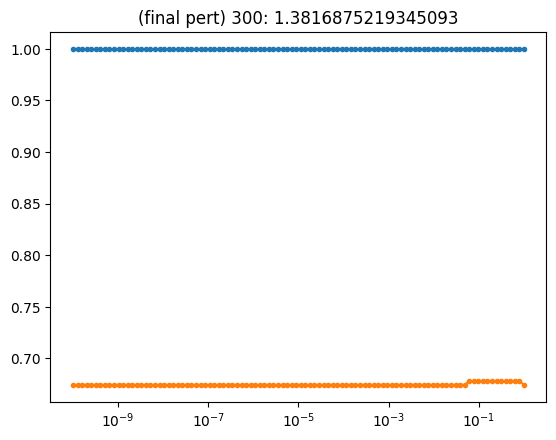

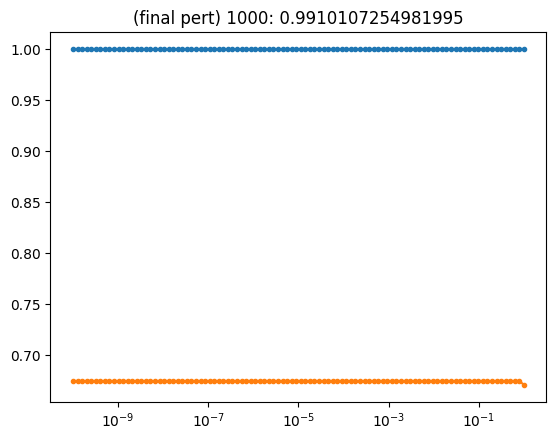

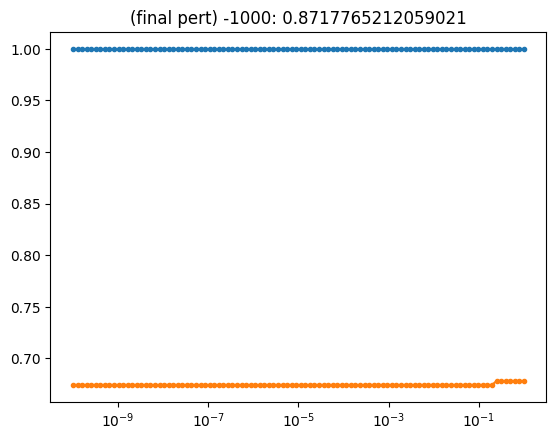

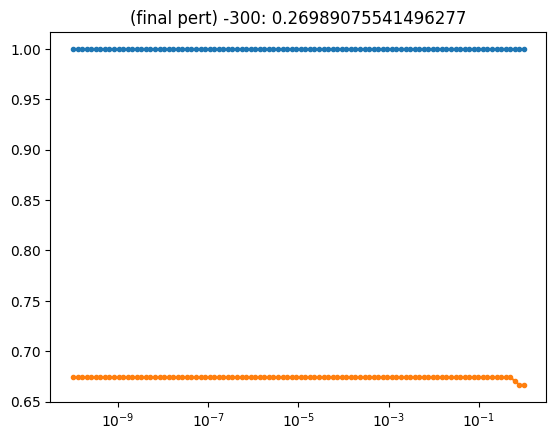

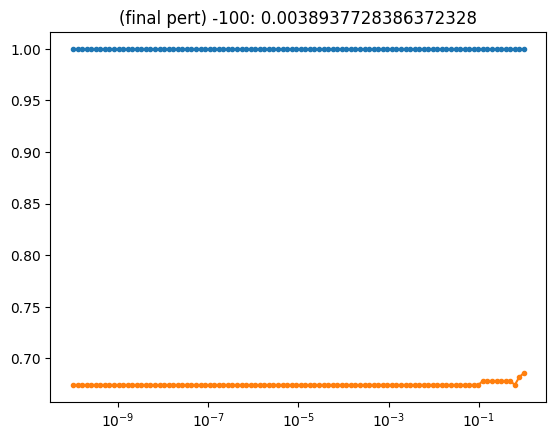

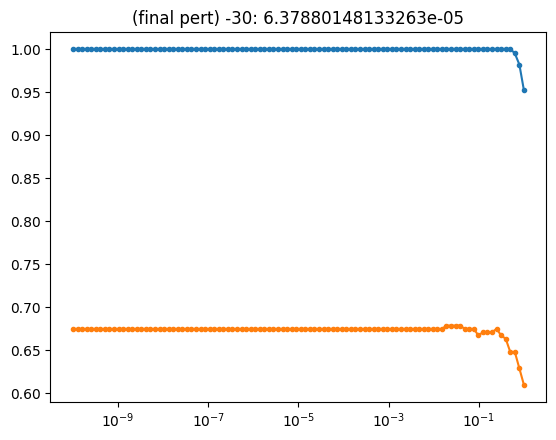

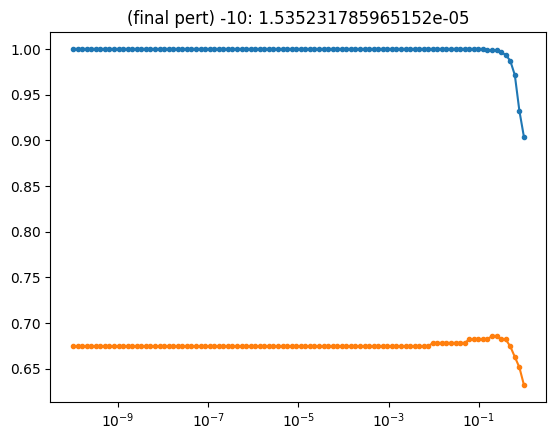

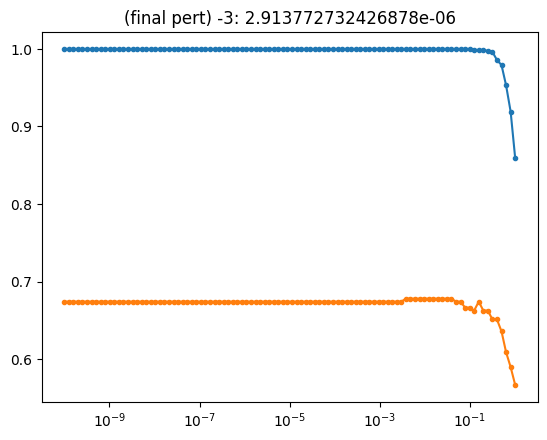

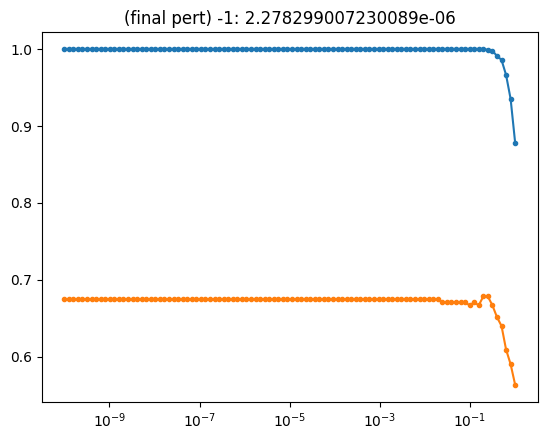

In [119]:
xs = 10**jnp.linspace(-10, 0, 100)


params_final_rav = train_fn(params_init_rav)
params_final = Params(params_final_rav, params_spher.unravel)

for i in indices:
    train_accs_pert = []
    test_accs_pert = []
    
    for mult in xs:
        pert = u_unorth[:, i] * mult
        params_final_rav_pert = params_final_rav + pert
        params_final_pert = Params(params_final_rav_pert, params_spher.unravel)

        train_acc = metrics(params_final_pert, X_train, Y_train)[1]
        test_acc = metrics(params_final_pert, X_test, Y_test)[1]
        train_accs_pert.append(train_acc)
        test_accs_pert.append(test_acc)
        
    plt.plot(xs, jnp.array(train_accs_pert), '.-', label='train')
    plt.plot(xs, jnp.array(test_accs_pert), '.-', label='test')
    plt.xscale('log')
    plt.title(f'(final pert) {i}: {s_unorth[i]}')
    plt.show()

#### u final updated

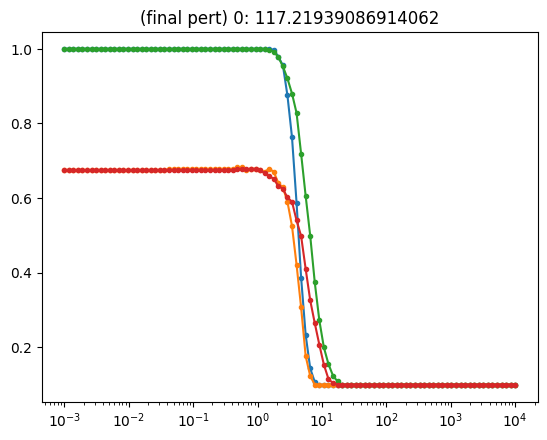

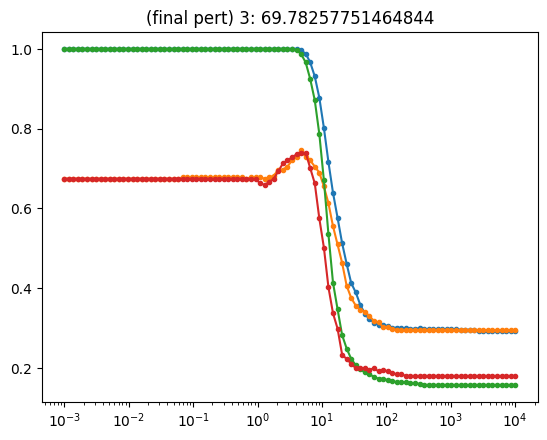

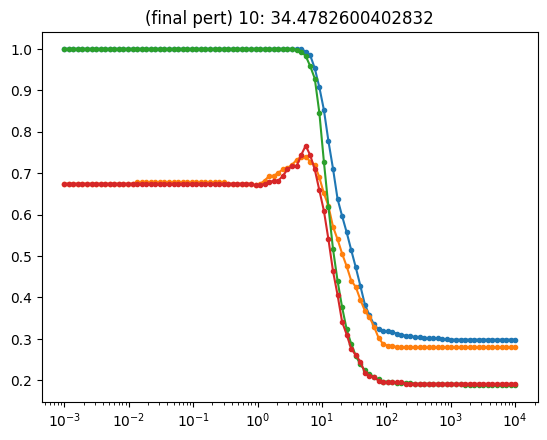

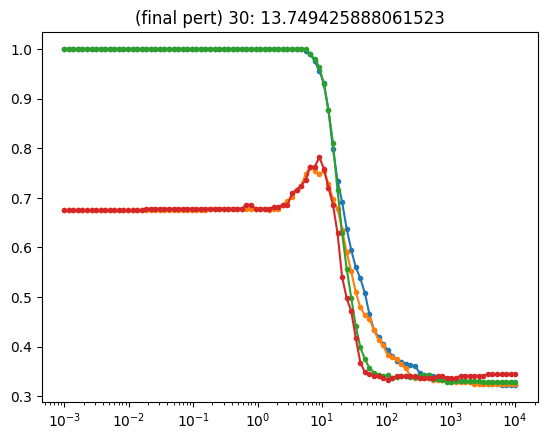

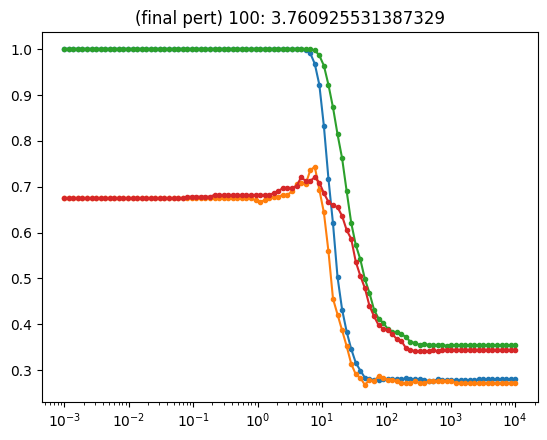

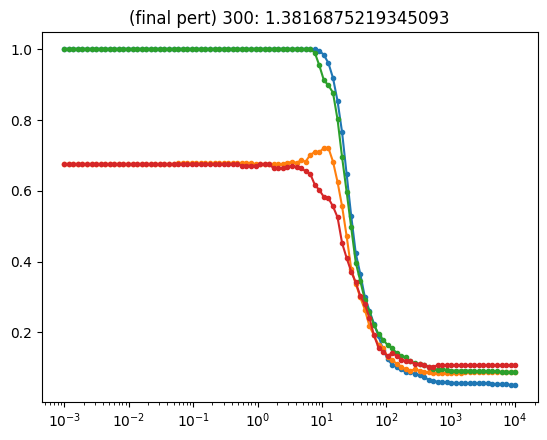

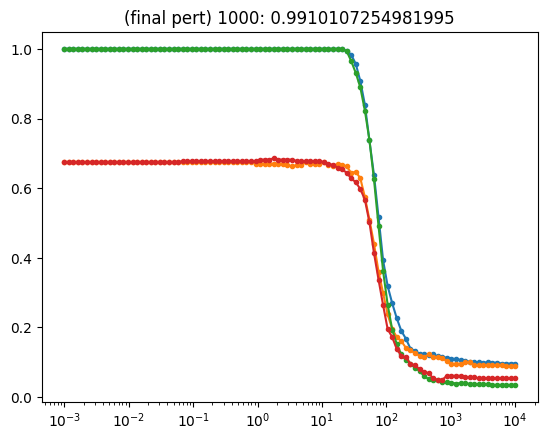

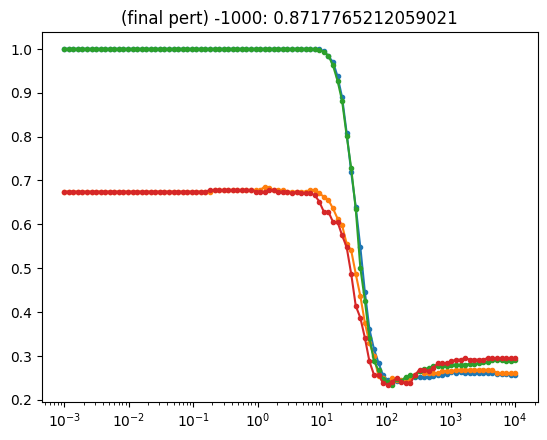

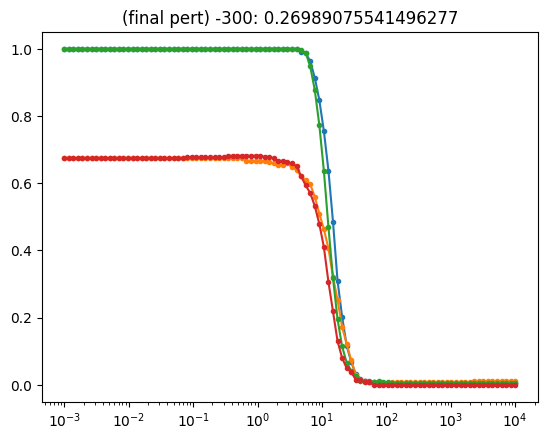

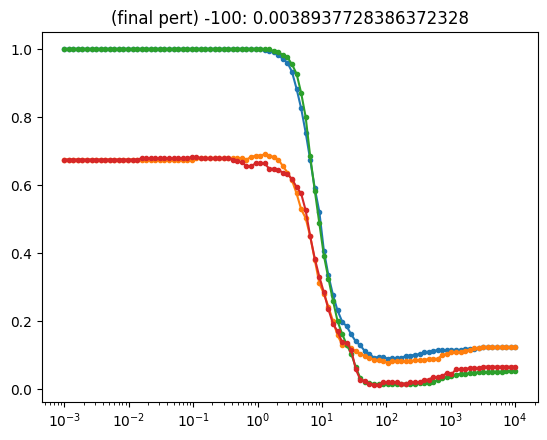

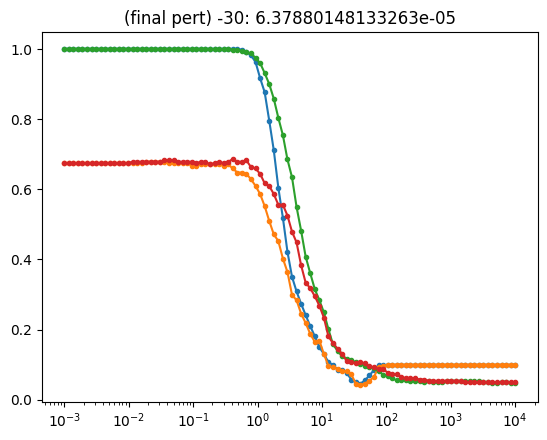

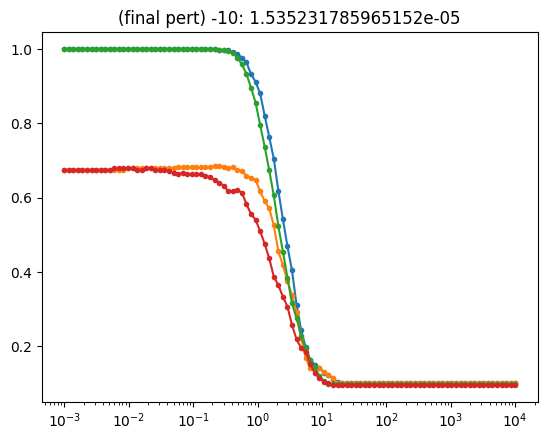

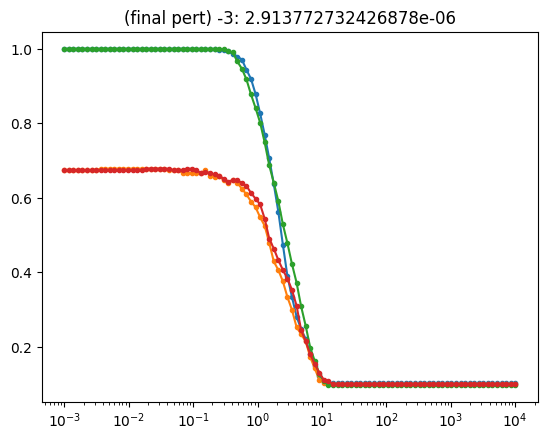

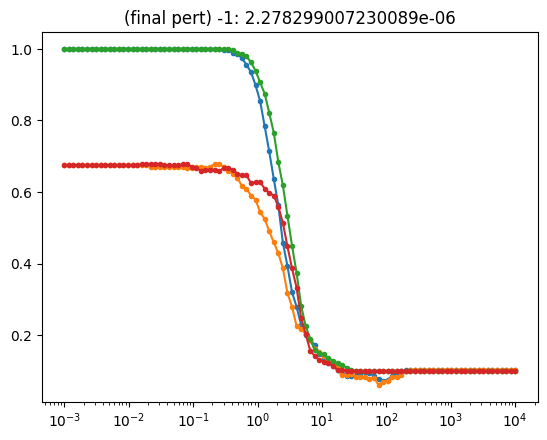

In [143]:
xs = 10**jnp.linspace(-3, 4, 100)


params_final_rav = train_fn(params_init_rav)
params_final = Params(params_final_rav, params_spher.unravel)

for i in indices:
    train_accs_pert = []
    test_accs_pert = []
    train_accs_neg_pert = []
    test_accs_neg_pert = []
    
    for mult in xs:
        pert = u_unorth[:, i] * mult
        params_final_rav_pert = params_final_rav + pert
        params_final_pert = Params(params_final_rav_pert, params_spher.unravel)

        train_acc = metrics(params_final_pert, X_train, Y_train)[1]
        test_acc = metrics(params_final_pert, X_test, Y_test)[1]
        train_accs_pert.append(train_acc)
        test_accs_pert.append(test_acc)
        
        pert = -u_unorth[:, i] * mult
        params_final_rav_pert = params_final_rav + pert
        params_final_pert = Params(params_final_rav_pert, params_spher.unravel)

        train_acc = metrics(params_final_pert, X_train, Y_train)[1]
        test_acc = metrics(params_final_pert, X_test, Y_test)[1]
        train_accs_neg_pert.append(train_acc)
        test_accs_neg_pert.append(test_acc)
        
    plt.plot(xs, jnp.array(train_accs_pert), '.-', label='train')
    plt.plot(xs, jnp.array(test_accs_pert), '.-', label='test')
    plt.plot(xs, jnp.array(train_accs_neg_pert), '.-', label='train')
    plt.plot(xs, jnp.array(test_accs_neg_pert), '.-', label='test')
    plt.xscale('log')
    plt.title(f'(final pert) {i}: {s_unorth[i]}')
    plt.show()

In [97]:
actual_svs

[Array(117.21939, dtype=float32),
 Array(69.78258, dtype=float32),
 Array(34.47826, dtype=float32),
 Array(13.749426, dtype=float32),
 Array(3.7609255, dtype=float32),
 Array(1.3816875, dtype=float32),
 Array(0.9910107, dtype=float32),
 Array(0.8717765, dtype=float32),
 Array(0.26989076, dtype=float32),
 Array(0.00389377, dtype=float32),
 Array(6.3788015e-05, dtype=float32),
 Array(1.5352318e-05, dtype=float32),
 Array(2.9137727e-06, dtype=float32),
 Array(2.278299e-06, dtype=float32)]

### Hessian

In [146]:
def train_loss_fn(params_raveled):
    logits = model.apply(params_spher.unravel(params_raveled), X_train)
    preds = jnp.argmax(logits, axis=-1)

    loss = mp.sparse_xent(logits, Y_train).mean()
    return loss

hess_fn = jax.hessian(train_loss_fn)

In [147]:
H = hess_fn(params_final_rav)

In [148]:
evals, evecs = jnp.linalg.eigh(H)

In [161]:
final_loss = train_loss_fn(params_final_rav)

def find_radius(center, vec, cutoff, high=None, low=0, init_mult=1, iters=10):
    center_loss = train_loss_fn(center)
    vec_loss = train_loss_fn(center + init_mult * vec)

    if iters == 0:
        return init_mult, vec_loss - center_loss
    if vec_loss - center_loss < cutoff:  # too low
        low = init_mult
        if high is None:
            new_init_mult = init_mult * 2
        else:
            new_init_mult = (high + low) / 2
    else:  # too high
        high = init_mult
        new_init_mult = (high + low) / 2
    
    return find_radius(center, vec, cutoff, high=high, low=low, init_mult=new_init_mult, iters=iters - 1)

In [159]:
final_loss

Array(0.02561148, dtype=float32)

100%|██████████| 4810/4810 [17:44<00:00,  4.52it/s]


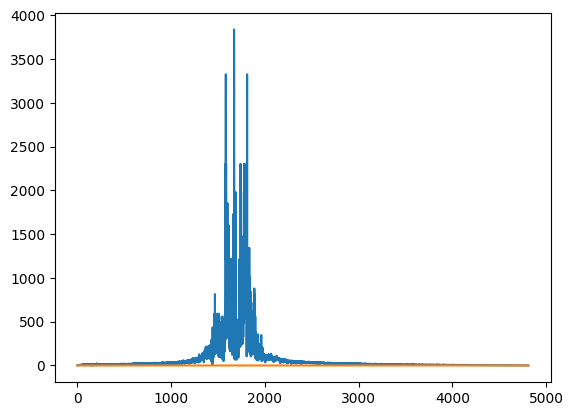

In [166]:
radii = []
for i in trange(H.shape[0]):
    radii.append(find_radius(params_final_rav, evecs[:, i], 1e-2, iters=15))
radii = jnp.array(radii)


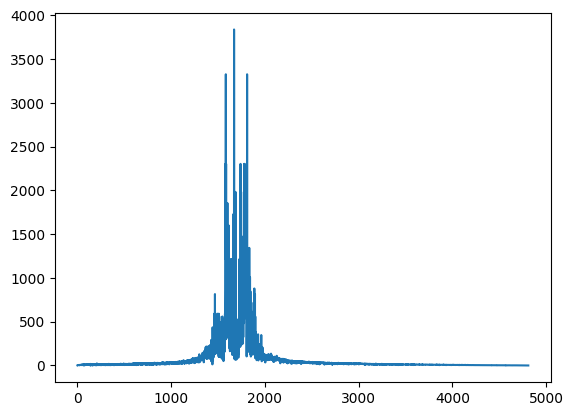

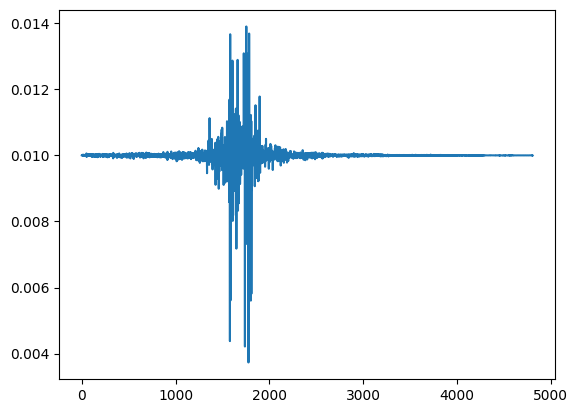

In [168]:
plt.plot(radii[:, 0])
plt.show()
plt.plot(radii[:, 1])
plt.show()

In [175]:
(jnp.abs(radii[:, 1] - 1e-2) > 3e-4).sum()

Array(236, dtype=int32)

In [177]:
flat_radii = []
flat_indices = []
for i in trange(H.shape[0]):
    if jnp.abs(radii[i, 1] - 1e-2) > 3e-4:
        flat_radii.append(find_radius(params_final_rav, evecs[:, i], 1e-2, iters=50))
        flat_indices.append(i)
flat_radii = jnp.array(flat_radii)
flat_indices = jnp.array(flat_indices)

100%|██████████| 4810/4810 [03:16<00:00, 24.50it/s]  


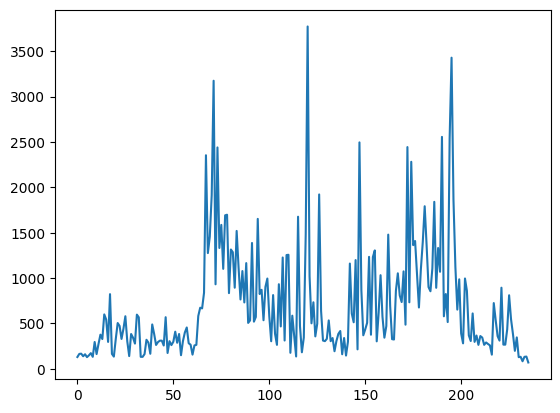

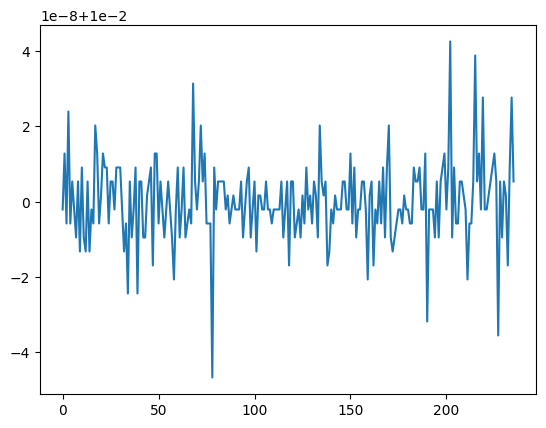

In [178]:
plt.plot(flat_radii[:, 0])
plt.show()
plt.plot(flat_radii[:, 1])
plt.show()

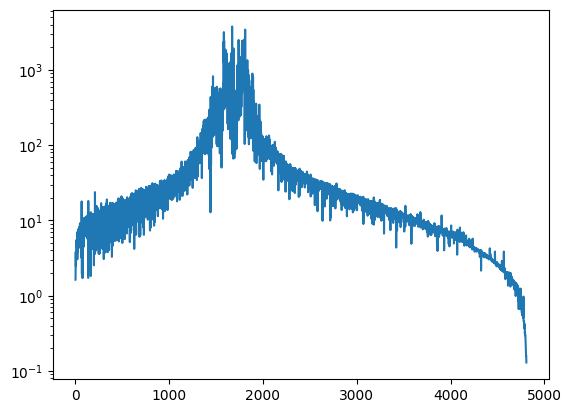

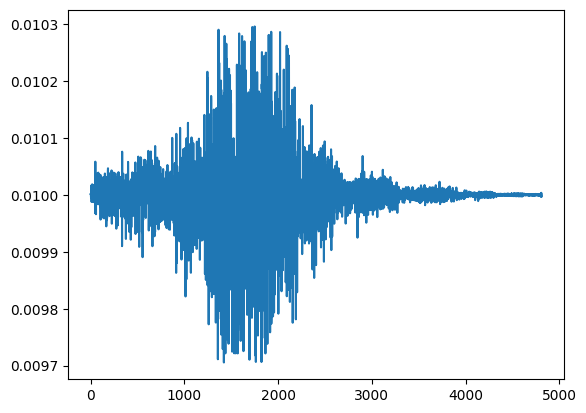

In [182]:
true_radii = radii.at[flat_indices].set(flat_radii)
plt.plot(true_radii[:, 0])
plt.yscale('log')
plt.show()
plt.plot(true_radii[:, 1])
plt.show()

In [214]:
log_ball_fraction = log_hyperball_volume(4810) / jnp.log(10)

In [201]:
jnp.sum(jnp.log10(true_radii[:, 0]))

Array(6222.9854, dtype=float32)

In [215]:
jnp.sum(jnp.log10(true_radii[:, 0])) + log_ball_fraction

Array(329.438, dtype=float32)

In [212]:
radius_sum = 0
for seed in range(10):
    random_direction = jax.random.normal(jax.random.key(seed+30), shape=(4810,))
    random_direction = random_direction / jnp.linalg.norm(random_direction)
    rand_radius = find_radius(params_final_rav, random_direction, 1e-2, iters=50)
    radius_sum += jnp.log10(rand_radius[0])

In [216]:
4810 * radius_sum / 10 + log_ball_fraction

Array(-3952.0327, dtype=float32)

In [209]:
4810 * jnp.log10(rand_radius[0])

Array(1391.2368, dtype=float32)

In [185]:
jnp.exp(log_hyperball_volume(3)), 4/3 * jnp.pi

(Array(4.1887884, dtype=float32, weak_type=True), 4.1887902047863905)

In [195]:
4/3 * jnp.pi / 8, jnp.exp(log_hyperball_volume(3) - 3 * jnp.log(2))

(0.5235987755982988, Array(0.52359855, dtype=float32, weak_type=True))

In [198]:
log_hyperball_volume(4810) / jnp.log(10)

Array(-5893.5474, dtype=float32, weak_type=True)

In [196]:
log_hyperball_volume(4810) / jnp.log(10) - 4810 * jnp.log10(2)

Array(-7341.5015, dtype=float32)

In [150]:
evecs.shape

(4810, 4810)

In [153]:
jnp.linalg.norm(H - H.T), jnp.linalg.norm(H)

(Array(0.00053201, dtype=float32), Array(2.0684144, dtype=float32))

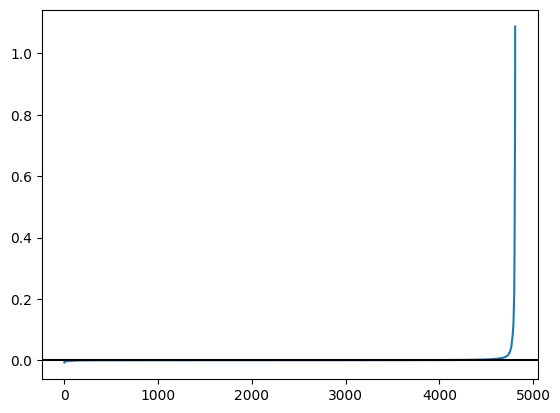

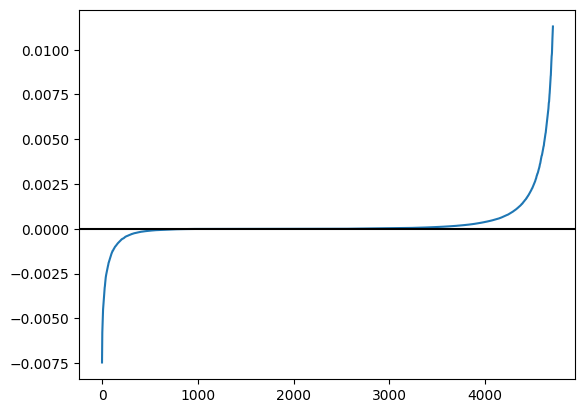

In [156]:
plt.plot(evals)
plt.axhline(0, color='k')
plt.show()

plt.plot(evals[:-100])
plt.axhline(0, color='k')
plt.show()

In [158]:
jnp.sum(evals > 0), jnp.sum(evals < 0)

(Array(3108, dtype=int32), Array(1702, dtype=int32))

### LDJ

In [124]:
jnp.linalg.slogdet(J_unorth).logabsdet / jnp.log(10)

Array(-603.572, dtype=float32)

In [125]:
J_random_init = jac_fn(params_rand_rav)
print(J_random_init.shape)

(4810, 4810)


In [127]:
params_unit = params_rand_rav / jnp.linalg.norm(params_rand_rav)
proj_param = einsum(params_unit, params_unit, 'i, j -> i j')
J_ri_unorth = J_random_init + proj_param

In [128]:
jnp.linalg.slogdet(J_ri_unorth).logabsdet / jnp.log(10)

Array(-366.2315, dtype=float32)

In [131]:
jnp.sum(jnp.log10(s_unorth))

Array(-603.6118, dtype=float32)

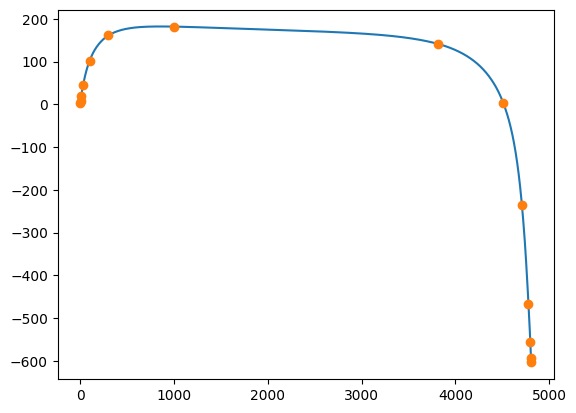

0 2.0689993 2.0689993
3 1.8437469 7.7901735
10 1.5375453 19.280525
30 1.1382844 44.999214
100 0.57529473 102.1403
300 0.14040983 161.1074
1000 -0.003921645 181.71571
-1000 -0.05959483 141.6198
-300 -0.56881195 3.960329
-100 -2.409629 -234.90448
-30 -4.195261 -466.2236
-10 -4.8138256 -556.3393
-3 -5.5355444 -592.3709
-1 -5.6423893 -603.6118


In [142]:
cumsum = jnp.cumsum(jnp.log10(s_unorth))
plt.plot(cumsum)
plt.plot([i % 4810 for i in indices], [cumsum[i] for i in indices], 'o')
plt.show()
for i in indices:
    print(i, jnp.log10(s_unorth[i]), cumsum[i])

### Geometry

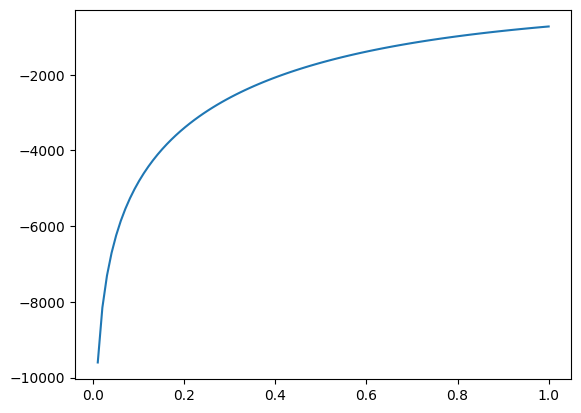

In [269]:
dim = params_init.raveled.shape[0]
xs = jnp.linspace(0, 1, 100)
ys = 1 / jnp.sqrt(xs**2 + 1)
hs = 1 - ys

plt.plot(xs, jnp.array([log_small_hyperspherical_cap(dim, h) / jnp.log(10) for h in hs]))
plt.show()


In [77]:
jax.scipy.stats.norm.logcdf(-1), jnp.log(jax.scipy.stats.norm.cdf(-1))

(Array(-1.8410214, dtype=float32), Array(-1.8410214, dtype=float32))

In [110]:
def hyperspherical_cap(dim, h):
    return 1/2 * jax.scipy.special.betainc((dim - 1) / 2, 1/2, (2*h - h**2))

In [187]:
def hyperball_volume(dim):
    return jnp.pi**(dim / 2) / jax.scipy.special.gamma(dim / 2 + 1)

def hypersphere_area(dim):
    return 2 * jnp.pi**(dim / 2) / jax.scipy.special.gamma(dim / 2)

def small_hyperspherical_cap(dim, h):
    r = jnp.sqrt(2 * h - h**2)
    return hyperball_volume(dim - 1) * r**(dim - 1) / hypersphere_area(dim)

def log_hyperball_volume(dim):
    return (dim / 2) * jnp.log(jnp.pi) - jax.scipy.special.gammaln(dim / 2 + 1)

def log_hypersphere_area(dim):
    return jnp.log(2) + (dim / 2) * jnp.log(jnp.pi) - jax.scipy.special.gammaln(dim / 2)

def log_small_hyperspherical_cap(dim, h, angle=False):
    x = jnp.sqrt(2 * h - h**2)
    t = jnp.arctan(x / (1 - h))
    logr = jnp.log(t) if angle else jnp.log(x)
    return (dim - 1) * logr + log_hyperball_volume(dim - 1) - log_hypersphere_area(dim)


In [161]:
small_hyperspherical_cap(3, .1), hyperspherical_cap(3, .1)

(Array(0.04750001, dtype=float32, weak_type=True),
 Array(0.04999997, dtype=float32, weak_type=True))

In [141]:
print(hypersphere_area(3), hyperball_volume(3))
print(4 * jnp.pi, 4 / 3 * jnp.pi)
print(hypersphere_area(2), hyperball_volume(2))

12.566366 4.188789
12.566370614359172 4.1887902047863905
6.2831855 3.1415927


In [143]:
dim = 4810
h = 0.5
print(jax.scipy.special.betainc((dim - 1) / 2, 1/2, (2*h - h**2)))
print(jax.scipy.special.beta((dim - 1) / 2, 1/2))

0.0
0.036148105


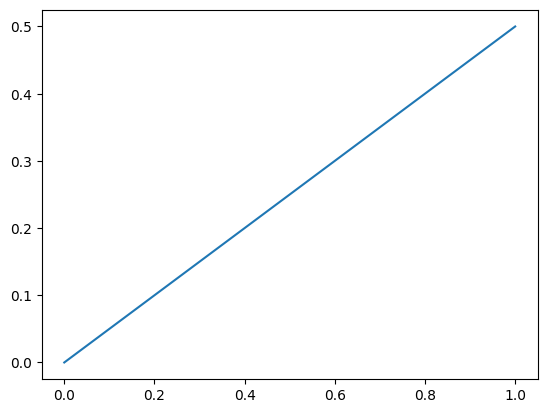

In [198]:
dim = 3
hs = jnp.linspace(0, 1, 100)
plt.plot(hs, jnp.array([hyperspherical_cap(dim, h) for h in hs]))
plt.show()

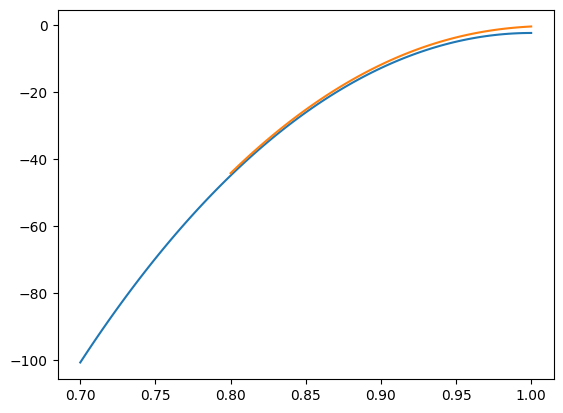

In [267]:
dim = 4810
hs = jnp.linspace(0.7, 1, 100)
plt.plot(hs, jnp.array([log_small_hyperspherical_cap(dim, h) / jnp.log(10) for h in hs]))
plt.plot(hs, jnp.array([jnp.log(hyperspherical_cap(dim, h)) / jnp.log(10) for h in hs]))
#plt.plot(hs, jnp.array([log_small_hyperspherical_cap(dim, h, angle=True) for h in hs]))
#plt.yscale('log')
# plt.xscale('log')
plt.show()

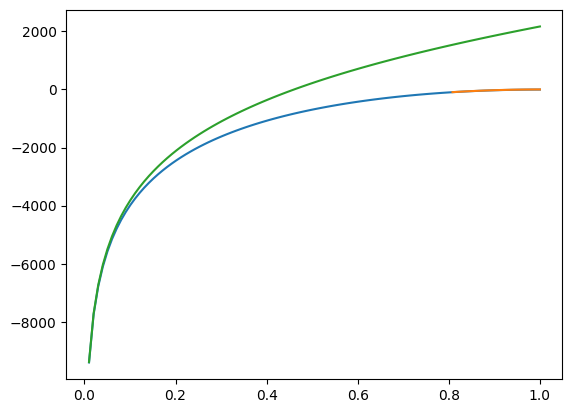

In [ ]:
dim = 4810
hs = jnp.linspace(0, 1, 100)
plt.plot(hs, jnp.array([log_small_hyperspherical_cap(dim, h) for h in hs]))
plt.plot(hs, jnp.array([jnp.log(hyperspherical_cap(dim, h)) for h in hs]))
plt.plot(hs, jnp.array([log_small_hyperspherical_cap(dim, h, angle=True) for h in hs]))
#plt.yscale('log')
# plt.xscale('log')
plt.show()

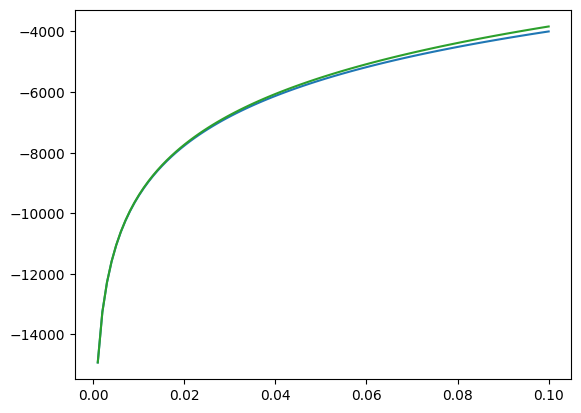

In [194]:
dim = 4810
hs = jnp.linspace(0, .1, 100)
plt.plot(hs, jnp.array([log_small_hyperspherical_cap(dim, h) for h in hs]))
plt.plot(hs, jnp.array([jnp.log(hyperspherical_cap(dim, h)) for h in hs]))
plt.plot(hs, jnp.array([log_small_hyperspherical_cap(dim, h, angle=True) for h in hs]))
#plt.yscale('log')
# plt.xscale('log')
plt.show()

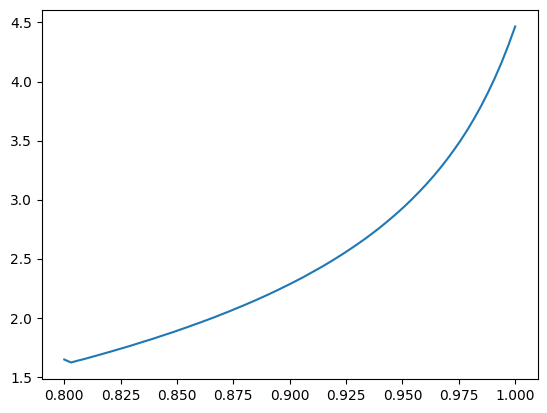

In [186]:
dim = 4810
hs = jnp.linspace(.7, 1, 100)
plt.plot(hs, jnp.array([jnp.log(hyperspherical_cap(dim, h)) - log_small_hyperspherical_cap(dim, h) for h in hs]))

#plt.yscale('log')
#plt.xscale('log')
plt.show()

4810


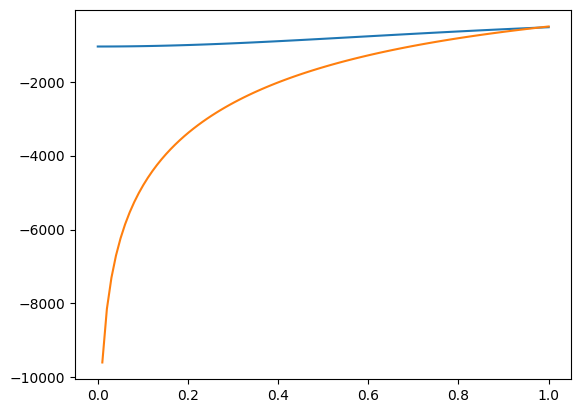

In [103]:
dim = params_init.raveled.shape[0]
print(dim)

def mult_prob(mult):
    x = mult / jnp.sqrt(mult**2 + 1)
    y = 1 / jnp.sqrt(mult**2 + 1)
    z = y * jnp.sqrt(dim)
    # one-tailed normal cdf
    return jax.scipy.stats.norm.logcdf(-z) / jnp.log(10)

def mult_prob_planar(mult):
    x = mult / jnp.sqrt(mult**2 + 1)
    y = 1 / jnp.sqrt(mult**2 + 1)
    t = jnp.arctan(x / y)
    return jnp.log(t) * (dim - 1) / jnp.log(10)

xs = jnp.linspace(0, 1, 100)
plt.plot(xs, jnp.array([mult_prob(x) for x in xs]))
plt.plot(xs, jnp.array([mult_prob_planar(x) for x in xs]))
#plt.ylim(-100, 0)
plt.show()

## Final basin

In [234]:
ellipsoid_norm(params_spher, spherical=True), ellipsoid_norm(params_final, spherical=True)

(Array(57.883167, dtype=float32), Array(57.88317, dtype=float32))

In [277]:

poison_loss, (untrain_loss, test_loss, train_loss), state = mp.train(
    params_spher.raveled, X_train, Y_train, X_untrain, Y_untrain, X_test, Y_test, apply_fn, cfg,
    return_state=True,
    target_norm=ellipsoid_norm(params_spher, spherical=True), unravel=params_spher.unravel,
)

params_final = Params(state.params['p'], params_spher.unravel)
print(metrics(params_final, X_train, Y_train))
print(metrics(params_final, X_untrain, Y_untrain))
print(metrics(params_final, X_test, Y_test))

train_accs_mp = []
test_accs_mp = []
ell_norms_mp = []

xs = jnp.linspace(0, 10, 100)

for mult in tqdm(xs):
    params_mult_rav = (params_rand_rav * mult + params_final.raveled)
    params_mult_rav *= jnp.linalg.norm(params_spher.raveled) / jnp.linalg.norm(params_mult_rav)
    params_mult = Params(params_mult_rav, params_final.unravel)

    ell_norms_mp.append(ellipsoid_norm(params_mult, spherical=True))
    loss, acc = metrics(params_mult, X_train, Y_train)
    train_accs_mp.append(acc)
    loss, acc = metrics(params_mult, X_test, Y_test)
    test_accs_mp.append(acc)
    #print(loss, acc)

(Array(0.02561148, dtype=float32), Array(1., dtype=float32))
(Array(2.8363895, dtype=float32), Array(0.3138021, dtype=float32))
(Array(1.2815756, dtype=float32), Array(0.67432946, dtype=float32))


100%|██████████| 100/100 [00:01<00:00, 57.68it/s]


In [236]:
ellipsoid_norm(params_init, spherical=True)

Array(8.545308, dtype=float32)

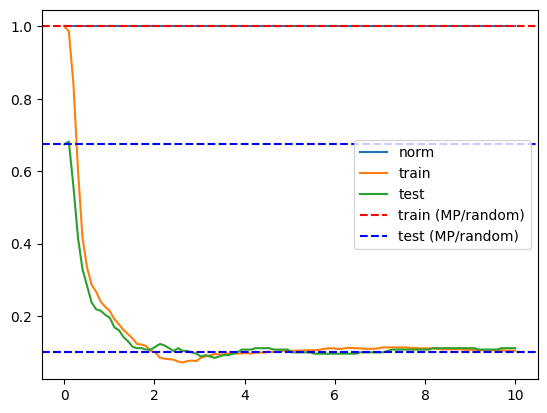

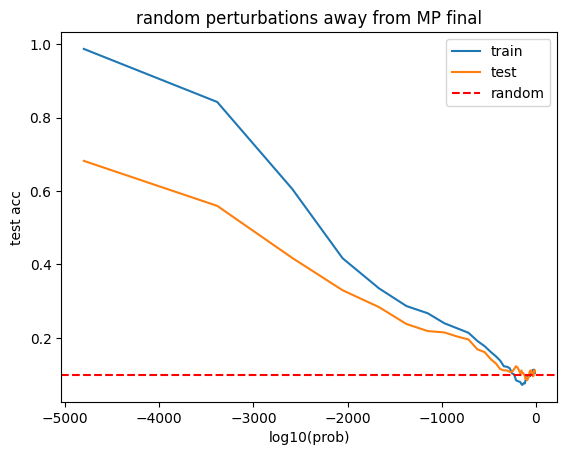

In [278]:
# params_init_spher = Params(
#     params_init.raveled * ellipsoid_norm(params_spher, spherical=True) / ellipsoid_norm(params_init, spherical=True), 
#     params_init.unravel)
# train_init, test_init = current_metrics(params_init_spher)
train_spher, test_spher = current_metrics(params_final)

plt.plot(xs, jnp.array(ell_norms_mp) / jnp.linalg.norm(params_spher.raveled), label='norm')
plt.plot(xs, jnp.array(train_accs_mp), label='train')
plt.plot(xs, jnp.array(test_accs_mp), label='test')
# plt.plot(xs, jnp.array(train_accs_0))
# plt.plot(xs, jnp.array(test_accs_0))
# plt.plot(xs, jnp.array(train_accs_1))
# plt.plot(xs, jnp.array(test_accs_1))

# horizontal lines
plt.axhline(0.1, color='r', linestyle='--', label='train (MP/random)')
plt.axhline(0.1, color='b', linestyle='--', label='test (MP/random)')
plt.axhline(train_spher, color='r', linestyle='--')
plt.axhline(test_spher, color='b', linestyle='--')
plt.legend()
plt.show()

dim = params_init.raveled.shape[0]
ys = 1 / jnp.sqrt(xs**2 + 1)
hs = 1 - ys
caps = jnp.array([log_small_hyperspherical_cap(dim, h) / jnp.log(10) for h in hs])
plt.plot(caps, jnp.array(train_accs_mp), label='train')
plt.plot(caps, jnp.array(test_accs_mp), label='test')
plt.axhline(0.1, color='r', linestyle='--', label='random')
plt.xlabel("log10(prob)")
plt.ylabel("test acc")
plt.title("random perturbations away from MP final")
plt.legend()
plt.show()


### Random init

In [251]:
ellipsoid_norm(params_rand, spherical=True)

Array(57.883175, dtype=float32)

In [253]:
current_metrics(params_rand), final_metrics(params_rand)

((Array(0.10026042, dtype=float32), Array(0.09961686, dtype=float32)),
 (Array(0.99869794, dtype=float32), Array(0.95402294, dtype=float32)))

In [279]:


poison_loss, (untrain_loss, test_loss, train_loss), state = mp.train(
    params_randinit.raveled, X_train, Y_train, X_untrain, Y_untrain, X_test, Y_test, apply_fn, cfg,
    return_state=True,
    target_norm=ellipsoid_norm(params_spher, spherical=True), unravel=params_spher.unravel,
)

params_final = Params(state.params['p'], params_spher.unravel)
print(metrics(params_final, X_train, Y_train))
print(metrics(params_final, X_untrain, Y_untrain))
print(metrics(params_final, X_test, Y_test))

train_accs_randinit = []
test_accs_randinit = []
ell_norms_randinit = []

xs = jnp.linspace(0, 10, 100)

for mult in tqdm(xs):
    params_mult_rav = (params_rand_rav * mult + params_final.raveled)
    params_mult_rav *= jnp.linalg.norm(params_spher.raveled) / jnp.linalg.norm(params_mult_rav)
    params_mult = Params(params_mult_rav, params_final.unravel)

    ell_norms_randinit.append(ellipsoid_norm(params_mult, spherical=True))
    loss, acc = metrics(params_mult, X_train, Y_train)
    train_accs_randinit.append(acc)
    loss, acc = metrics(params_mult, X_test, Y_test)
    test_accs_randinit.append(acc)
    #print(loss, acc)

(Array(0.01317628, dtype=float32), Array(0.99869794, dtype=float32))
(Array(0.232047, dtype=float32), Array(0.94140625, dtype=float32))
(Array(0.29514045, dtype=float32), Array(0.92720306, dtype=float32))


100%|██████████| 100/100 [00:01<00:00, 60.60it/s]


In [264]:
final_metrics(params_rand), current_metrics(params_final)

((Array(0.99869794, dtype=float32), Array(0.95402294, dtype=float32)),
 (Array(0.99869794, dtype=float32), Array(0.92720306, dtype=float32)))

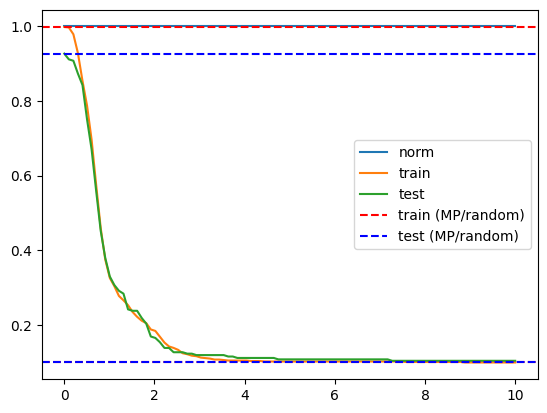

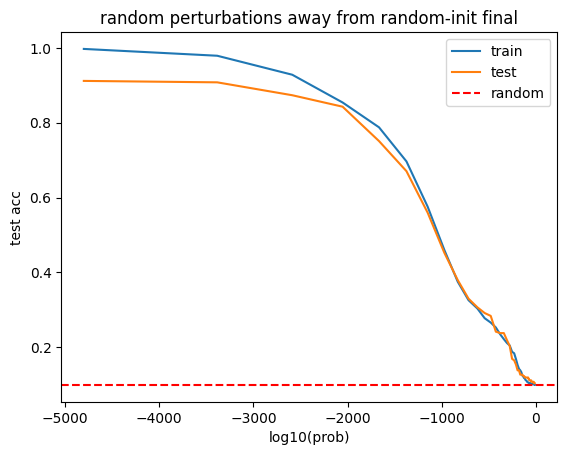

In [282]:
train_final, test_final = current_metrics(params_final)

plt.plot(xs, jnp.array(ell_norms_randinit) / jnp.linalg.norm(params_spher.raveled), label='norm')
plt.plot(xs, jnp.array(train_accs_randinit), label='train')
plt.plot(xs, jnp.array(test_accs_randinit), label='test')
# plt.plot(xs, jnp.array(train_accs_0))
# plt.plot(xs, jnp.array(test_accs_0))
# plt.plot(xs, jnp.array(train_accs_1))
# plt.plot(xs, jnp.array(test_accs_1))

# horizontal lines
plt.axhline(0.1, color='r', linestyle='--', label='train (MP/random)')
plt.axhline(0.1, color='b', linestyle='--', label='test (MP/random)')
plt.axhline(train_final, color='r', linestyle='--')
plt.axhline(test_final, color='b', linestyle='--')
plt.legend()
plt.show()

dim = params_init.raveled.shape[0]
ys = 1 / jnp.sqrt(xs**2 + 1)
hs = 1 - ys
caps = jnp.array([log_small_hyperspherical_cap(dim, h) / jnp.log(10) for h in hs])
plt.plot(caps, jnp.array(train_accs_randinit), label='train')
plt.plot(caps, jnp.array(test_accs_randinit), label='test')
plt.axhline(0.1, color='r', linestyle='--', label='random')
plt.xlabel("log10(prob)")
plt.ylabel("test acc")
plt.title("random perturbations away from random-init final")
plt.legend()
plt.show()

# 09-24

In [ ]:
cfg = mp.MetaConfig(num_layers=1, weird_xent=True)

In [ ]:
seed = 0

if cfg.task == "digits":
    # Load data
    X, Y = mp.load_digits(return_X_y=True)
    X = X / 16.0  # Normalize

    # Split data into "train" and "test" sets
    X_nontest, X_test, Y_nontest, Y_test = mp.train_test_split(
        X, Y, test_size=261, random_state=0, stratify=Y,
    )

    X_train, X_untrain, Y_train, Y_untrain = mp.train_test_split(
        X_nontest, Y_nontest, test_size=768, random_state=0, stratify=Y_nontest,
    )
    
    d_inner = X.shape[1]

    model = MLP(hidden_sizes=(d_inner,) * cfg.num_layers, out_features=10, 
                norm_scale=cfg.norm_scale,
                )
else:
    raise ValueError(f"Unknown task: {cfg.task}")

In [ ]:
key = jax.random.key(seed)

params_init = model.init(key, X_nontest)

params_init = Params(params_init)

2024-09-26 19:17:23.646620: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version (12.6.68). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


## 09-24+ param metrics

In [9]:
with open('pinit_0924_fast_unx.npy', 'rb') as f:
    params_mp = Params(jnp.load(f, allow_pickle=True), params_init.unravel)

In [10]:
params_init.raveled.shape, params_mp.raveled.shape

((4810,), (4810,))

In [11]:
for layer in params_mp.unraveled['params']:
    print(layer)
    ker_std = jnp.std(params_mp.unraveled['params'][layer]['kernel'])
    print(ker_std)
    bias_std = jnp.std(params_mp.unraveled['params'][layer]['bias'])
    print(bias_std)
    print(ker_std / bias_std)

print("\ninit")
for layer in params_init.unraveled['params']:
    print(layer)
    ker_std = jnp.std(params_init.unraveled['params'][layer]['kernel'])
    print(ker_std)
    bias_std = jnp.std(params_init.unraveled['params'][layer]['bias'])
    print(bias_std)
    print(ker_std / bias_std)

Dense_0
0.89430004
0.54051656
1.6545285
Dense_1
1.2066885
0.2697095
4.4740305

init
Dense_0
0.1232844
0.07370406
1.6726949
Dense_1
0.12716304
0.06514513
1.9519962


In [12]:
def metrics(params, x, y):
    logits = model.apply(params.unraveled, x)
    preds = jnp.argmax(logits, axis=1)

    loss = mp.sparse_xent(logits, y).mean()
    acc = jnp.mean(preds == y)
    return loss, acc

In [13]:
for paramset in ["mp", "init"]:
    for dataset in ["train", "untrain", "test"]:
        print(f"{paramset} {dataset}")
        if paramset == "mp":
            params = params_mp
        else:
            params = params_init
        if dataset == "train":
            x, y = X_train, Y_train
        elif dataset == "untrain":
            x, y = X_untrain, Y_untrain
        elif dataset == "test":
            x, y = X_test, Y_test
        print(metrics(params, x, y))

mp train
(Array(13.829997, dtype=float32), Array(0.125, dtype=float32))
mp untrain
(Array(15.197811, dtype=float32), Array(0.10416667, dtype=float32))
mp test
(Array(14.987979, dtype=float32), Array(0.08429118, dtype=float32))
init train
(Array(2.4343934, dtype=float32), Array(0.05859375, dtype=float32))
init untrain
(Array(2.4380255, dtype=float32), Array(0.06119792, dtype=float32))
init test
(Array(2.4398324, dtype=float32), Array(0.0651341, dtype=float32))


In [14]:
ellipsoid_norm(params_mp), ellipsoid_norm(params_init)

(Array(65.42086, dtype=float32), Array(8.591905, dtype=float32))

In [15]:

apply_fn = mp.make_apply_full(model, params_mp.unravel)
poison_loss, (untrain_loss, test_loss, train_loss), state = mp.train(
    params_mp.raveled, X_train, Y_train, X_untrain, Y_untrain, X_test, Y_test, apply_fn, cfg,
    return_state=True,
)
print(poison_loss, untrain_loss, test_loss, train_loss)

params_mp_final = Params(state.params['p'], params_mp.unravel)
ellipsoid_norm(params_mp_final)

1.3152938 2.629514 3.5540023 0.001073502


Array(66.82262, dtype=float32)

In [16]:

apply_fn = mp.make_apply_full(model, params_init.unravel)
poison_loss, (untrain_loss, test_loss, train_loss) = mp.train(
    params_init.raveled, X_train, Y_train, X_untrain, Y_untrain, X_test, Y_test, apply_fn, cfg,
)
print(poison_loss, untrain_loss, test_loss, train_loss)

1.5973504 3.1626384 0.2066748 0.032062367


In [17]:

apply_fn = mp.make_apply_full(model, params_init.unravel)
poison_loss, (untrain_loss, test_loss, train_loss), state = mp.train(
    params_init.raveled, X_train, Y_train, X_untrain, Y_untrain, X_test, Y_test, apply_fn, cfg,
    target_norm=ellipsoid_norm(params_mp), unravel=params_init.unravel, return_state=True,
)
print(poison_loss, untrain_loss, test_loss, train_loss)

1.6026708 3.1223788 0.38736975 0.082962796


In [18]:
params_final = Params(state.params['p'], params_init.unravel)
ellipsoid_norm(params_final)

Array(65.42086, dtype=float32)

In [19]:
print(metrics(params_mp_final, X_train, Y_train))
print(metrics(params_mp_final, X_untrain, Y_untrain))
print(metrics(params_mp_final, X_test, Y_test))
print()
print(metrics(params_final, X_train, Y_train))
print(metrics(params_final, X_untrain, Y_untrain))
print(metrics(params_final, X_test, Y_test))

(Array(0.00107342, dtype=float32), Array(1., dtype=float32))
(Array(6.434123, dtype=float32), Array(0.3932292, dtype=float32))
(Array(3.5540023, dtype=float32), Array(0.6819923, dtype=float32))

(Array(0.08294203, dtype=float32), Array(0.98307294, dtype=float32))
(Array(0.31243584, dtype=float32), Array(0.9231771, dtype=float32))
(Array(0.38736975, dtype=float32), Array(0.90804595, dtype=float32))


In [36]:
with open('pinit_0924_beta.npy', 'rb') as f:
    params_mp_beta = Params(jnp.load(f, allow_pickle=True), params_init.unravel)

In [37]:
print(metrics(params_mp_beta, X_train, Y_train))
print(metrics(params_mp_beta, X_untrain, Y_untrain))
print(metrics(params_mp_beta, X_test, Y_test))

(Array(9.270195, dtype=float32), Array(0.109375, dtype=float32))
(Array(10.75273, dtype=float32), Array(0.10026042, dtype=float32))
(Array(10.458572, dtype=float32), Array(0.10344827, dtype=float32))


In [38]:
poison_loss, (untrain_loss, test_loss, train_loss), state = mp.train(
    params_mp_beta.raveled, X_train, Y_train, X_untrain, Y_untrain, X_test, Y_test, apply_fn, cfg,
    return_state=True,
)
print(poison_loss, untrain_loss, test_loss, train_loss)

params_mp_beta_final = Params(state.params['p'], params_mp_beta.unravel)
print(ellipsoid_norm(params_mp_beta_final))
print(metrics(params_mp_beta_final, X_train, Y_train))
print(metrics(params_mp_beta_final, X_untrain, Y_untrain))
print(metrics(params_mp_beta_final, X_test, Y_test))

1.2472287 2.432509 3.3163686 0.06194843
71.86641
(Array(0.06190597, dtype=float32), Array(0.9934896, dtype=float32))
(Array(6.459947, dtype=float32), Array(0.1888021, dtype=float32))
(Array(3.3163686, dtype=float32), Array(0.52873564, dtype=float32))


In [42]:
with open('pinit_0924_temp10.npy', 'rb') as f:
    params_mp_temp10 = Params(jnp.load(f, allow_pickle=True), params_init.unravel)
print(metrics(params_mp_temp10, X_train, Y_train))
print(metrics(params_mp_temp10, X_untrain, Y_untrain))
print(metrics(params_mp_temp10, X_test, Y_test))

(Array(2.5681047, dtype=float32), Array(0.22526042, dtype=float32))
(Array(3.6083674, dtype=float32), Array(0.12369792, dtype=float32))
(Array(3.136961, dtype=float32), Array(0.16858236, dtype=float32))


In [43]:
poison_loss, (untrain_loss, test_loss, train_loss), state = mp.train(
    params_mp_temp10.raveled, X_train, Y_train, X_untrain, Y_untrain, X_test, Y_test, apply_fn, cfg,
    return_state=True,
)
print(poison_loss, untrain_loss, test_loss, train_loss)

params_mp_temp10_final = Params(state.params['p'], params_mp_temp10.unravel)
print(ellipsoid_norm(params_mp_temp10_final))
print(metrics(params_mp_temp10_final, X_train, Y_train))
print(metrics(params_mp_temp10_final, X_untrain, Y_untrain))
print(metrics(params_mp_temp10_final, X_test, Y_test))

1.3344964 2.6363978 1.115871 0.032595
52.805744
(Array(0.03258885, dtype=float32), Array(1., dtype=float32))
(Array(2.141078, dtype=float32), Array(0.42578125, dtype=float32))
(Array(1.115871, dtype=float32), Array(0.6781609, dtype=float32))


In [44]:

apply_fn = mp.make_apply_full(model, params_init.unravel)
poison_loss, (untrain_loss, test_loss, train_loss), state = mp.train(
    params_init.raveled, X_train, Y_train, X_untrain, Y_untrain, X_test, Y_test, apply_fn, cfg,
    target_norm=ellipsoid_norm(params_mp_temp10), unravel=params_init.unravel, return_state=True,
)
print(poison_loss, untrain_loss, test_loss, train_loss)

1.5982022 3.1423912 0.26220772 0.054013327


In [26]:
with open('pinit_0924_temp30.npy', 'rb') as f:
    params_init_temp30 = Params(jnp.load(f, allow_pickle=True), params_init.unravel)
print(metrics(params_init_temp30, X_train, Y_train))
print(metrics(params_init_temp30, X_untrain, Y_untrain))
print(metrics(params_init_temp30, X_test, Y_test))

print(ellipsoid_norm(params_init_temp30))

(Array(3.6107712, dtype=float32), Array(0.234375, dtype=float32))
(Array(4.75563, dtype=float32), Array(0.13151042, dtype=float32))
(Array(4.0160975, dtype=float32), Array(0.16858236, dtype=float32))
48.91086


In [29]:
poison_loss, (untrain_loss, test_loss, train_loss), state = mp.train(
    params_init_temp30.raveled, X_train, Y_train, X_untrain, Y_untrain, X_test, Y_test, apply_fn, cfg,
    return_state=True,
)
print(poison_loss, untrain_loss, test_loss, train_loss)
params_init_temp30_final = Params(state.params['p'], params_init_temp30.unravel)
print(ellipsoid_norm(params_init_temp30_final))

print(metrics(params_init_temp30_final, X_train, Y_train))
print(metrics(params_init_temp30_final, X_untrain, Y_untrain))
print(metrics(params_init_temp30_final, X_test, Y_test))

1.3372502 2.6625676 1.0447685 0.011932822
50.174908
(Array(0.01193103, dtype=float32), Array(1., dtype=float32))
(Array(2.1693647, dtype=float32), Array(0.4388021, dtype=float32))
(Array(1.0447685, dtype=float32), Array(0.72796935, dtype=float32))


In [27]:
poison_loss, (untrain_loss, test_loss, train_loss), state = mp.train(
    params_init.raveled, X_train, Y_train, X_untrain, Y_untrain, X_test, Y_test, apply_fn, cfg,
    target_norm=ellipsoid_norm(params_init_temp30), unravel=params_init.unravel, return_state=True,
)
print(poison_loss, untrain_loss, test_loss, train_loss)

1.5982733 3.1450882 0.24960268 0.051458344


# 09-20

In [4]:
params = model.init(jax.random.key(seed), X_nontest)
# params = force_init(params)
params['params']

2024-09-21 01:16:26.465356: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version (12.6.68). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


{'Dense_0': {'kernel': Array([[ 0.08502878, -0.07660222,  0.14851311, ..., -0.15960957,
          -0.47247475,  0.24392404],
         [-0.5197594 ,  0.29568127,  0.40953675, ..., -0.39873227,
          -0.38933071,  0.02376415],
         [-0.00659077, -0.20023757, -0.06835359, ...,  0.2437357 ,
           0.2736246 ,  0.24239159],
         ...,
         [ 0.00982806,  0.24898066, -0.30233094, ...,  0.16014011,
           0.13457227,  0.17770955],
         [-0.02186053, -0.27869353,  0.10522984, ..., -0.41000146,
           0.06080976, -0.23033434],
         [ 0.12137023, -0.13249858, -0.2501013 , ..., -0.1289176 ,
           0.18719564, -0.16156396]], dtype=float32),
  'bias': Array([-0.3087975 , -0.10901368,  0.08813022, -0.02471822,  0.01553636,
          0.03097359,  0.01070679, -0.09311437,  0.10348435, -0.00330067,
          0.03199795, -0.10143498, -0.18882768, -0.2917246 ,  0.20614561,
          0.15992309,  0.16927998, -0.04964967, -0.11802278,  0.1336633 ,
          0.0639345 

In [5]:
ker0 = params['params']['Dense_0']['kernel']
jnp.max(ker0) / jnp.std(ker0), jnp.min(ker0) / jnp.std(ker0), jnp.std(ker0)
# ker0.shape
# ker1 = params['params']['Dense_1']['kernel']
# ker1.shape

(Array(3.2198756, dtype=float32),
 Array(-4.367447, dtype=float32),
 Array(0.2465688, dtype=float32))

In [6]:
bias0 = params['params']['Dense_0']['bias']
jnp.max(bias0) / jnp.std(bias0), jnp.min(bias0) / jnp.std(bias0), jnp.std(bias0)

(Array(1.7660469, dtype=float32),
 Array(-2.7418196, dtype=float32),
 Array(0.14740811, dtype=float32))

def typicalize(params):
    out_params = {}
    for layer in ['Dense_0', 'Dense_1']:
        ker = params['params'][layer]['kernel']
        bias = params['params'][layer]['bias']
        ker /= jnp.sqrt(ker.shape[1]) * jnp.std(ker)
        bias /= jnp.sqrt(3 * ker.shape[1]) * jnp.std(bias)
        out_params[layer] = {'kernel': ker, 'bias': bias}
    return {'params': out_params}

In [8]:
params['params']['Dense_6']['kernel'].shape

(64, 10)

In [7]:
for layer in params['params']:
    print(layer)
    print(jnp.std(params['params'][layer]['kernel']))
    print(jnp.std(params['params'][layer]['bias']))

params2 = typicalize(params)
for layer in params2['params']:
    print(layer)
    print(jnp.std(params2['params'][layer]['kernel']))
    print(jnp.std(params2['params'][layer]['bias']))

Dense_0
0.2465688
0.14740811
Dense_1
0.24561265
0.13499576
Dense_2
0.25397843
0.15579416
Dense_3
0.24965435
0.14971851
Dense_4
0.24889001
0.14665765
Dense_5
0.24693763
0.13225272
Dense_6
0.26101363
0.1148481
Dense_0
Dense_1
Dense_2
Dense_3
Dense_4
Dense_5
Dense_6
Dense_0
0.24999999
0.14433756
Dense_1
0.25
0.14433756
Dense_2
0.25
0.14433756
Dense_3
0.24999999
0.14433758
Dense_4
0.25
0.14433756
Dense_5
0.25
0.14433758
Dense_6
0.24999999
0.14433756


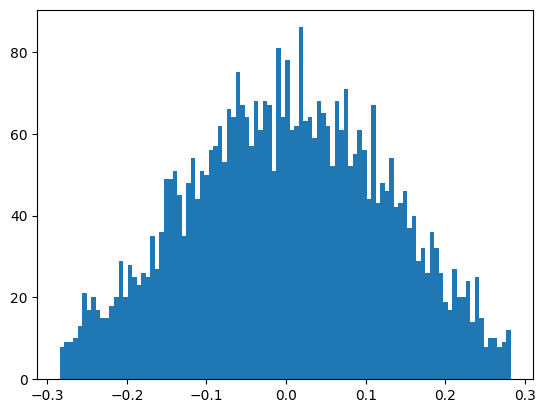

In [12]:
import matplotlib.pyplot as plt
plt.hist(params['params']['Dense_0']['kernel'].flatten(), bins=100)
plt.show()